In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, block_diag, identity, hstack, csr_matrix, csc_matrix
import matplotlib.pyplot as plt
from pyiga import assemble, bspline, vform, geometry, vis, solvers, utils, topology, ieti, algebra
from pyiga import ieti_cy, geometry_cy
#from sksparse.cholmod import cholesky
from pyiga import adaptive as adap
import json
from os.path import exists
import itertools
from scipy.sparse.linalg import aslinearoperator

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)
sys.setrecursionlimit(10000)
#import numba as nb    
#from numba import njit

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [22]:
class IetiDP:
    def __init__(self, MP, dir_data, neu_data=None, elim=True):
        self.space = MP
        self.elim = elim
        self.dir_idx=dict()
        self.dir_vals=dict()
        kvs = self.space.mesh.kvs
        geos = self.space.mesh.geos
        for key in dir_data:
            for p,b in self.space.mesh.outer_boundaries[key]:
                idx_, vals_ = assemble.compute_dirichlet_bc(kvs[p], geos[p], [(b//2,b%2)], dir_data[key])
                if p in self.dir_idx:
                    self.dir_idx[p].append(idx_)
                    self.dir_vals[p].append(vals_)
                else:
                    self.dir_idx[p]=[idx_]
                    self.dir_vals[p]=[vals_]
                
        for p in self.dir_idx:
            self.dir_idx[p], lookup = np.unique(np.concatenate(self.dir_idx[p]), return_index = True)
            self.dir_vals[p] = np.concatenate(self.dir_vals[p])[lookup]
        
        if self.elim:
            p_intfs = np.array([[p1,p2] for (p1,_,_),(p2,_,_),_ in self.space.intfs], dtype=np.int32).T
            self.Basisk, self.N_ofs, self.N, self.B = ieti_cy.pyx_compute_decoupled_coarse_basis(self.space.Basis.tocsc(), MP.N_ofs.astype(np.int32), p_intfs)
        else:
            self.Basisk = [scipy.sparse.identity(self.space.N[p]) for p in range(self.space.numpatches)]
            self.B = self.space.Constr
            
        self.N = [Ba.shape[1] for Ba in self.Basisk]
        self.N_ofs = np.cumsum([0]+self.N)
        self.Bk = [self.B[:,self.N_ofs[p]:self.N_ofs[p+1]] for p in range(self.space.numpatches)]
        self.Basis=scipy.sparse.block_diag(self.Basisk).tocsr()
        self.P2Gk =[]
        
        for p in range(self.space.numpatches):
            X = self.Basisk[p].tocoo()
            idx = np.where(np.isclose(X.data,1))
            X.data, X.row, X.col = X.data[idx], X.row[idx], X.col[idx]
            D = (X.T@self.Basisk[p]).sum(axis=1).A.ravel()
            #assert all(abs(D)>1e-12), 'D has zeros.'
            #S = scipy.sparse.spdiags(1/D,[0],len(D),len(D))
            self.P2Gk.append(X.T)
            I = np.zeros(self.Basisk[p].shape[0])
            if p in self.dir_idx:
                I[self.dir_idx[p]] = 1
                self.dir_idx[p] = np.where(np.isclose(self.P2Gk[p]@I,1))[0]
        self.P2G = scipy.sparse.block_diag(self.P2Gk)
        
        if len(self.dir_idx)>0:
            self.global_dir_idx = np.concatenate([self.dir_idx[p] + self.N_ofs[p] for p in self.dir_idx])
        else:
            self.global_dir_idx = np.array([])
        self.free_dofs = np.setdiff1d(np.arange(self.N_ofs[-1]),self.global_dir_idx)
        self.free_dofs_pp = [np.arange(self.N[p]) if p not in self.dir_idx else np.setdiff1d(np.arange(self.N[p]),self.dir_idx[p]) for p in range(self.space.numpatches)]
        self.R_interior = {}
        self.R_skeleton = {}
        self.R_interfaces = {}
        for p in range(self.space.numpatches):
            Id = scipy.sparse.eye(self.N[p], format='csr')
            mask_skeleton = np.zeros(self.N[p], dtype=bool)
            intfs = np.where(self.Bk[p].getnnz(0) > 0)[0]
            #mask_skeleton[intfs]=True
            mask_interior = np.ones(self.N[p], dtype=bool)
            mask_interior[intfs]=False
            if p in self.dir_idx:
                mask_interior[self.dir_idx[p]]=False
                #mask_skeleton[self.dir_idx[p]]=False
            self.R_interior[p]=Id[mask_interior]
            for b in range(4):
                if not any([(p,b) in self.space.mesh.outer_boundaries[key] for key in self.space.mesh.outer_boundaries]):
                    mask_intf = np.zeros(self.N[p], dtype=bool)
                    interface_dofs = assemble.boundary_dofs(kvs[p],bdspec=[(b//2,b%2)],ravel=True)
                    mask_intf[interface_dofs] = True
                    if p in self.dir_idx:
                        mask_intf[self.dir_idx[p]]=False
                    mask_skeleton += mask_intf
                    self.R_interfaces[(p,b)] = Id[mask_intf]
            self.R_skeleton[p] = Id[mask_skeleton]
        self.Ck = [np.empty((0,self.space.N[p])) for p in range(self.space.numpatches)]
        self.Rk = []
        self.Prim={}
            
    def assemble(self, problem, f, a):
        self.Ak = [Ba.T @ assemble.assemble(problem, kvs, a=a[self.space.mesh.patch_domains[k]], bfuns=[('u',1), ('v',1)], geo=geo)@Ba for k, (Ba, ((kvs, geo),_)) in enumerate(zip(self.Basisk, self.space.mesh.patches))]
        self.rhsk = [Ba.T @ assemble.assemble('f * v * dx', kvs, bfuns=[('v',1)], geo=geo, f=f[self.space.mesh.patch_domains[k]]).ravel() for k, (Ba, ((kvs, geo),_)) in enumerate(zip(self.Basisk,self.space.mesh.patches))]
        self.BCRestr = {p:assemble.RestrictedLinearSystem(self.Ak[p], self.rhsk[p], (self.dir_idx[p],self.dir_vals[p])) for p in self.dir_idx}
        self.rhsk = [rhsk if p not in self.dir_idx else self.BCRestr[p].b for p, rhsk in enumerate(self.rhsk)]
        self.Ak = [Ak if p not in self.dir_idx else self.BCRestr[p].A for p, Ak in enumerate(self.Ak)]
        
    def generate_prim(self, elim, fat):
        Nodes = self.space.get_nodes()
        self.Prim = {}
        i=0
        total_dofs=set()
        
        if elim:
            if fat:
                for key in Nodes:
                    if isinstance(key,np.int32):
                        dofs = self.Basis.tocsr()[Nodes[key][0],:].indices
                        self.Prim[i] = (dofs,np.ones(len(dofs)))
                        i+=1
                    else:
                        dofs = self.Basis.tocsr()[Nodes[key][1],:].indices
                        for dof in dofs:
                            if dof not in total_dofs:
                                total_dofs.add(dof)
                                dofs = np.unique(self.B.tocsr()[self.B.tocsc()[:,dof].indices,:].indices)
                                self.Prim[i] = (dofs,np.ones(len(dofs)))
                                i+=1
            else:
                for key in Nodes:
                    if isinstance(key,np.int32):
                        dofs = self.Basis.tocsr()[Nodes[key][0],:].indices
                        self.Prim[i] = (dofs,np.ones(len(dofs)))
                        i+=1
                    else:
                        constr = (self.space.Constr.tocsc()[:,Nodes[key][0][0]]==1).indices
                        coeffs = abs(self.space.Constr[constr,:][:,Nodes[key][1]].data)
                        dofs_coarse = self.Basis.tocsr()[Nodes[key][1],:].indices
                        dofs=[]
                        for dof in dofs_coarse:
                            found_dofs = np.unique(self.B.tocsr()[self.B.tocsc()[:,dof].indices,:].indices)
                            dofs.append(found_dofs)
                        self.Prim[i] = (np.concatenate(dofs),np.repeat(coeffs,len(found_dofs)))
                        i+=1
        else:
            for key in Nodes:
                if isinstance(key,np.int32):    #regular corner
                    dofs = self.Basis.tocsr()[Nodes[key][0],:].indices
                    self.Prim[i] = (dofs,np.ones(len(dofs)))
                    i+=1
                else:                        #T-junction
                    constr = (self.space.Constr.tocsc()[:,Nodes[key][0][0]]==1).indices
                    coeffs = abs(self.space.Constr[constr,:][:,Nodes[key][1]].data)
                    dofs_coarse = Nodes[key][1]
                    dofs=np.concatenate([Nodes[key][0],Nodes[key][1]])
                    coeffs = np.concatenate([np.ones(len(Nodes[key][0])),coeffs])
                    self.Prim[i] = (dofs,coeffs)
                    i+=1
        
    def construct_primal_constraints(self, redundant=False, fat=True):
        self.Ck = []
        self.Rk = []
        kvs = self.space.mesh.kvs
        geos = self.space.mesh.geos
        self.eliminate_constraints = np.array([], dtype=int)
        Nodes=self.space.get_nodes(dir_boundary = True)
        
        self.generate_prim(elim=self.elim, fat=fat)
        if self.Prim:
            loc_c_prim = np.concatenate([self.Prim[key][0] for key in self.Prim])
            coeffs = np.concatenate([self.Prim[key][1] for key in self.Prim])
        else:
            loc_c_prim = np.array([])
            coeffs = np.array([])
        loc_c_prim_idx = np.repeat(np.arange(len(self.Prim)),[len(self.Prim[i][0]) for i in self.Prim])
        p_idx = [(loc_c_prim >= self.N_ofs[p]) & (loc_c_prim < self.N_ofs[p+1]) for p in range(self.space.numpatches)]
        self.Prim_pp = {p : (loc_c_prim[p_idx[p]],coeffs[p_idx[p]],loc_c_prim_idx[p_idx[p]]) for p in range(self.space.numpatches)}

        for (p1,b1) in self.space.L_intfs:
            R1 = self.R_interfaces[(p1,b1)]
            diag=np.ones(R1.shape[1])
            idx = np.where(np.isclose(self.Prim_pp[p1][1],1))[0]
            diag[self.Prim_pp[p1][0][idx]-self.N_ofs[p1]]=0
            R1 = R1@scipy.sparse.spdiags(diag,0,R1.shape[1],R1.shape[1])
            R1.eliminate_zeros()
            self.R_interfaces[(p1,b1)] = R1[R1.getnnz(1)>0,:]
            for (p2,b2) in self.space.L_intfs[(p1,b1)]:
                R2 = self.R_interfaces[(p2,b2)]
                diag=np.ones(R2.shape[1])
                idx = np.where(np.isclose(self.Prim_pp[p2][1],1))[0]
                diag[self.Prim_pp[p2][0][idx]-self.N_ofs[p2]]=0
                R2 = R2@scipy.sparse.spdiags(diag,0,R2.shape[1],R2.shape[1])
                R2.eliminate_zeros()
                self.R_interfaces[(p2,b2)] = R2[R2.getnnz(1)>0,:]
                    
        for p in range(MP.numpatches):
            c_primal_free = self.Prim_pp[p][0] - self.N_ofs[p]
            data = self.Prim_pp[p][1]
            idx = np.bincount(self.Prim_pp[p][2])
            idx = idx[idx>0]
            rows = np.repeat(np.arange(len(idx)),idx)
            cols = c_primal_free
            ck = coo_matrix((data, (rows, cols)),(len(idx),self.N[p])).tocsc()
            ck = ck[:,self.free_dofs_pp[p]]
            self.Ck.append(ck.tocsr())
            m, n = ck.shape[0], len(self.Prim)
            jj = np.unique(self.Prim_pp[p][2])
            self.Rk.append(scipy.sparse.coo_matrix((np.ones(m),(np.arange(m),jj)),(m,n)))
            
        if not redundant:
            if self.elim:
                if fat:
                    nnz_per_row = self.B[:,np.concatenate([self.Prim_pp[p][0] for p in range(self.space.numpatches)])].getnnz(axis=1)
                    self.eliminate_constraints = np.where(nnz_per_row > 0)[0]
                else:
                    dofs = [Nodes[key][0] for key in Nodes if isinstance(key,np.int32)]
                    if len(dofs)>0:
                        dofs = np.concatenate([Nodes[key][0] for key in Nodes if isinstance(key,np.int32)])
                    dofs_new = (self.Basis[dofs,:]==1).indices
                    self.eliminate_constraints = np.where(self.B[:,dofs_new].getnnz(axis=1))
            else:
                self.eliminate_constraints = (MP.Constr.tocsc()[:,np.concatenate([Nodes[key][0] for key in Nodes])]==1).indices
                    
        keep_constr = np.setdiff1d(np.arange(self.B.shape[0]),self.eliminate_constraints)
        self.B = self.B[keep_constr,:]
        self.Bk = [B[keep_constr,:] for B in self.Bk]
        self.C = scipy.sparse.block_diag(self.Ck)
        
    def construct_primal_basis(self):
        self.PsiK=[]
        self.Deltak=[]
        self.loc_solver = []
        self.A_prim = np.zeros(2*(len(self.Prim),))
        for p in range(len(self.space.mesh.patches)):
            a = self.Ak[p]
            c = self.Ck[p]
            RHS = np.vstack([np.zeros((a.shape[0],c.shape[0])), np.identity(c.shape[0])])
            self.loc_solver.append(solvers.make_solver(scipy.sparse.bmat([[a,    c.T], [c,    None]], format='csr'), spd=False, symmetric=True))
            psi = self.loc_solver[p].dot(RHS)
            psi, delta = psi[:a.shape[0],], psi[a.shape[0]:,]
            if psi.ndim==1: psi=psi[:,None]
            if delta.ndim==1: delta=delta[:,None]
            self.PsiK.append(psi@self.Rk[p])
            self.Deltak.append(delta)
            self.A_prim -= self.Rk[p].T@delta@self.Rk[p]
        self.Psi=np.vstack(self.PsiK)
        
    def remove_dir_from_system(self):
        self.B = self.B[:,self.free_dofs]
        #self.keep = np.where(self.B.getnnz(1)>0)[0]
        self.B=self.B[self.B.getnnz(1)>0,:]
        idx_p = [(self.free_dofs < self.N_ofs[p+1]) & (self.free_dofs >= self.N_ofs[p]) for p in range(self.space.numpatches)]
        self.Bk = [self.B[:,idx_p[p]] for p in range(self.space.numpatches)]
        for p in self.dir_idx:
            self.R_skeleton[p] = self.R_skeleton[p][:,self.free_dofs_pp[p]]
            self.R_interior[p] = self.R_interior[p][:,self.free_dofs_pp[p]]
            for b in range(4):
                if not any([(p,b) in self.space.mesh.outer_boundaries[key] for key in self.space.mesh.outer_boundaries]):
                    self.R_interfaces[(p,b)] = self.R_interfaces[(p,b)][:,self.free_dofs_pp[p]]

    def compute_F(self):
        self.Bk_ = [aslinearoperator(scipy.sparse.bmat([[b,np.zeros((b.shape[0],self.Ck[p].shape[0]))]], format='csr')) for p,b in enumerate(self.Bk)] 
        rhs = np.concatenate(self.rhsk)
        self.rhsk_ = [np.concatenate([f,np.zeros(self.Ck[p].shape[0])]) for p,f in enumerate(self.rhsk)]
        if len(self.Prim)==0:
            self.loc_solver = [solvers.make_solver(a, spd=False, symmetric=True) for a in self.Ak]
            self.Psi = np.empty((self.B.shape[1],0))
        self.BP = self.B@self.Psi
            
        F2 = np.array([b@Ak_inv.dot(b.T) for b, Ak_inv in zip(self.Bk_, self.loc_solver)]).sum()
        b2 = np.sum([b.dot(Ak_inv.dot(f)) for b, Ak_inv,f in zip(self.Bk_, self.loc_solver, self.rhsk_)],axis=0)
        if len(self.Prim)!=0:
            self.solver_prim = solvers.make_solver(self.A_prim, spd=True, symmetric=True)
            F1 = aslinearoperator(self.BP@self.solver_prim.dot(self.BP.T)) 
            b1 = self.BP@self.solver_prim.dot(self.Psi.T@rhs)
            return F1+F2, b1+b2
        return F2, b2

    def compute_S(self):
        B = self.B
        Bk = self.Bk
        self.B_gamma = scipy.sparse.hstack([Bk[p]@self.R_skeleton[p].T for p in range(self.space.numpatches)])
        self.Aii = [self.R_interior[p]@self.Ak[p]@self.R_interior[p].T for p in range(self.space.numpatches)]
        self.Abb = [aslinearoperator(self.R_skeleton[p]@self.Ak[p]@self.R_skeleton[p].T) for p in range(self.space.numpatches)]
        self.Abi = [aslinearoperator(self.R_skeleton[p]@self.Ak[p]@self.R_interior[p].T) for p in range(self.space.numpatches)]
        self.S = [Abb - Abi@solvers.make_solver(Aii, spd=True).dot(Abi.T) for Abb,Abi,Aii in zip(self.Abb,self.Abi,self.Aii)]
        self.S = [s@np.eye(s.shape[0]) for s in self.S]
        #self.schur_exact=True
        self.S_ofs = np.cumsum([0]+[s.shape[0] for s in self.S])

        # self.S_prim = np.zeros(2*(len(self.Prim),))
        # PsiK=[]
        # for p in range(self.space.numpatches):
        #     s = self.S[p]
        #     c = self.Ck[p]@self.R_skeleton[p].T
        #     RHS = np.vstack([np.zeros((s.shape[0],c.shape[0])), np.identity(c.shape[0])])
        #     sol = solvers.make_solver(scipy.sparse.bmat([[s,    c.T], [c,    None]], format='csr'), spd=False, symmetric=True)
        #     psi = sol.dot(RHS)
        #     psi, delta = psi[:s.shape[0],], psi[s.shape[0]:,]
        #     if psi.ndim==1: psi=psi[:,None]
        #     if delta.ndim==1: delta=delta[:,None]
        #     self.S_prim -= self.Rk[p].T@delta@self.Rk[p]
        #     PsiK.append(psi@self.Rk[p])
        # self.Psi_gamma=np.vstack(PsiK)
    
    def MsD(self, method="diagonal", as_matrix = False):
        if as_matrix:
            self.compute_S()
        else:
            B = self.B
            Bk = self.Bk
            self.B_gamma = scipy.sparse.hstack([Bk[p]@self.R_skeleton[p].T for p in range(self.space.numpatches)])
            self.Aii = [self.R_interior[p]@self.Ak[p]@self.R_interior[p].T for p in range(self.space.numpatches)]
            self.Abb = [aslinearoperator(self.R_skeleton[p]@self.Ak[p]@self.R_skeleton[p].T) for p in range(self.space.numpatches)]
            self.Abi = [aslinearoperator(self.R_skeleton[p]@self.Ak[p]@self.R_interior[p].T) for p in range(self.space.numpatches)]
            self.S = [Abb - Abi@solvers.make_solver(Aii, spd=True).dot(Abi.T) for Abb,Abi,Aii in zip(self.Abb,self.Abi,self.Aii)]
            self.S_ofs = np.cumsum([0]+[s.shape[0] for s in self.S])
                
        if method=="pseudo":   ###TODO: Do not compute matrix exactly but use least squares as an operator
            t=time.time()
            P = np.linalg.pinv(self.B_gamma.toarray())
            P[abs(P)<1e-12]=0
            self.BgD=scipy.sparse.csr_matrix(P).T
            print("Computing pseudoinverse took "+str(time.time()-t)+" seconds.")
        elif method=="diagonal":
            D = self.B_gamma.getnnz(axis=0)
            D = 1/(1+D)
            self.D = scipy.sparse.diags(D, format='csr')
            self.BgD = self.B_gamma@self.D
        elif method=="selection":
            B = self.B_gamma.tocsc()
            idx = 1*(B.indptr[1:]-B.indptr[:-1]==1) & np.isclose(B.sum(axis=0).A[0],1)
            self.D=scipy.sparse.diags([idx],[0])
            self.BgD = self.B_gamma@self.D
        elif method=="deluxe":
            M_deluxe=[]
            for (p1,b1) in self.space.L_intfs:
                R1 = scipy.sparse.vstack([self.R_interior[p1],self.R_interfaces[(p1,b1)]])
                c = self.Ck[p1]@R1.T
                c = c[c.getnnz(1)>0]
                A = [scipy.sparse.bmat([[R1@I.Ak[p1]@R1.T,c.T],[c,None]])]
                B = [scipy.sparse.hstack([self.Bk[p1]@R1.T,csc_matrix((self.Bk[p1].shape[0],c.shape[0]))])]
                P = []
                for (p2,b2) in self.space.L_intfs[(p1,b1)]:
                    R2 = scipy.sparse.vstack([self.R_interior[p2],self.R_interfaces[(p2,b2)]])
                    A.append(R2@self.Ak[p2]@R2.T)
                    B.append(self.Bk[p2]@R2.T)
                    P.append(self.B_gamma[:,(self.S_ofs[p2]):(self.S_ofs[p2+1])]@self.R_skeleton[p2]@self.R_interfaces[(p2,b2)].T)
                A = scipy.sparse.block_diag(A)
                B = scipy.sparse.hstack(B, format='csc')
                P = scipy.sparse.hstack(P, format='csc')
                r_idx = (B.getnnz(1)>0)
                n_c = sum(r_idx)
                Mat = -scipy.sparse.bmat([[A, B[r_idx,:].T],[B[r_idx,:], None]], format="csc")
                n = Mat.shape[0]
                B_ = B[r_idx,(R1.shape[0]+c.shape[0]):]
                c_idx = B_.getnnz(0)>0
                X = aslinearoperator(scipy.sparse.hstack([scipy.sparse.csc_matrix((P.shape[0],n-n_c)),P@B_[:,c_idx].T]))
                M_deluxe.append(X@solvers.make_solver(Mat, symmetric=True, spd=False).dot(X.T))
            return np.array(M_deluxe).sum()
            
        print("Convergence condition: "+str(scipy.sparse.linalg.norm(self.B_gamma@self.BgD.T@self.B_gamma-self.B_gamma)))
        # for p in range(self.space.numpatches):
        #     print(self.BgD[:,ofs[p]:ofs[p+1]].shape, self.S[p].shape, self.BgD[:,ofs[p]:ofs[p+1]].T.shape)
        if as_matrix:
            return np.array([self.BgD[:,self.S_ofs[p]:self.S_ofs[p+1]]@self.S[p]@self.BgD[:,self.S_ofs[p]:self.S_ofs[p+1]].T for p in range(self.space.numpatches)]).sum(axis=0)
        else:
            return sum([aslinearoperator(self.BgD[:,self.S_ofs[p]:self.S_ofs[p+1]])@self.S[p].dot(aslinearoperator(self.BgD[:,self.S_ofs[p]:self.S_ofs[p+1]].T)) for p in range(self.space.numpatches)])

    def construct_solution(self, lam):
        u=np.zeros(self.space.N_ofs[-1])
        u_prim = self.solver_prim.dot(self.Psi.T@(np.concatenate(self.rhsk)-self.B.T@lam))
        for p in range(self.space.numpatches):
            sol = self.loc_solver[p].dot(np.r_[self.rhsk[p]-self.Bk[p].T@lam,np.zeros(self.Ck[p].shape[0])])[:self.Ck[p].shape[1]] + self.PsiK[p]@u_prim
            if p in self.BCRestr:
                sol = self.BCRestr[p].complete(sol)
            u[self.space.N_ofs[p]:self.space.N_ofs[p+1]]=self.Basisk[p]@sol
        return u
        

In [23]:
def checkerboard(deg,N,k=0):
    geos = [
    geometry.unit_square(),
    geometry.unit_square().translate((1,0)),
    geometry.unit_square().translate((0,1)),
    geometry.unit_square().translate((1,1)),
    ]

    kvs=4*[2*(bspline.make_knots(deg,0.0,1.0,N),)]
    patches = [(kvs, g) for kvs, g in zip(kvs,geos)]

    # set up a PatchMesh object, which detects interfaces between patches
    M = topology.PatchMesh(patches)
    for j in range(k):
        M.h_refine(patches = {i : -1 for i in range(4) if i%2==1})
    return M

In [24]:
def checkerboard1(deg,N,k):
    geos = [
    geometry.unit_square(),
    geometry.unit_square().translate((1,0)),
    geometry.unit_square().translate((2,0)),
    geometry.unit_square().translate((0,1)),
    geometry.unit_square().translate((1,1)),
    geometry.unit_square().translate((2,1)),
    geometry.unit_square().translate((0,2)),
    geometry.unit_square().translate((1,2)),
    geometry.unit_square().translate((2,2)),
    ]

    #kvs = [2 * (bspline.make_knots(p, 0.0, 1.0, N),) if i%2==0 else 2 * (bspline.make_knots(p, 0.0, 1.0, k*N),) for i in range(len(geos))]
    #kvs = [2 * (bspline.make_knots(p, 0.0, 1.0, N),), 2 * (bspline.make_knots(p, 0.0, 1.0, k*N),),2 * (bspline.make_knots(p, 0.0, 1.0, k*N),), 2 * (bspline.make_knots(p, 0.0, 1.0, N),)] # 15
    kvs=9*[2*(bspline.make_knots(deg,0.0,1.0,N),)]
    patches = [(kvs, g) for kvs, g in zip(kvs,geos)]

    # set up a PatchMesh object, which detects interfaces between patches
    M = topology.PatchMesh(patches)
    for j in range(k):
        M.h_refine(patches = {i : -1 for i in range(9) if i%2==1})
    return M

In [25]:
def checkerboard2(deg,N,k):
    geos = [
        geometry.annulus(r1=1,r2=4/3,phi=np.pi/6),
        geometry.annulus(r1=4/3,r2=5/3,phi=np.pi/6),
        geometry.annulus(r1=5/3,r2=2,phi=np.pi/6),
        geometry.annulus(r1=1,r2=4/3,phi=np.pi/6).rotate_2d(np.pi/6),
        geometry.annulus(r1=4/3,r2=5/3,phi=np.pi/6).rotate_2d(np.pi/6),
        geometry.annulus(r1=5/3,r2=2,phi=np.pi/6).rotate_2d(np.pi/6),
        geometry.annulus(r1=1,r2=4/3,phi=np.pi/6).rotate_2d(np.pi/3),
        geometry.annulus(r1=4/3,r2=5/3,phi=np.pi/6).rotate_2d(np.pi/3),
        geometry.annulus(r1=5/3,r2=2,phi=np.pi/6).rotate_2d(np.pi/3),
    ]

    #kvs = [2 * (bspline.make_knots(p, 0.0, 1.0, N),) if i%2==0 else 2 * (bspline.make_knots(p, 0.0, 1.0, k*N),) for i in range(len(geos))]
    #kvs = [2 * (bspline.make_knots(p, 0.0, 1.0, N),), 2 * (bspline.make_knots(p, 0.0, 1.0, k*N),),2 * (bspline.make_knots(p, 0.0, 1.0, k*N),), 2 * (bspline.make_knots(p, 0.0, 1.0, N),)] # 15
    kvs=9*[2*(bspline.make_knots(deg,0.0,1.0,N),)]
    patches = [(kvs, g) for kvs, g in zip(kvs,geos)]

    # set up a PatchMesh object, which detects interfaces between patches
    M = topology.PatchMesh(patches)
    for j in range(k):
        M.h_refine(patches = {i : -1 for i in range(9) if i%2==0})
    return M

In [26]:
def Lshape(deg, N, depth=0):
 
    kvs = [2 * (bspline.make_knots(deg, 0.0, 1.0, N),),2 * (bspline.make_knots(deg, 0.0, 1.0, N),),2 * (bspline.make_knots(deg, 0.0, 1.0, N),)]

    # define geometry
    geos = [
        geometry.annulus(r1=1.5,phi=np.pi/4),
        geometry.annulus(r1=1.5,phi=np.pi/4).rotate_2d(np.pi/4),
        geometry.annulus(r1=1,r2=1.5,phi=np.pi/4).rotate_2d(np.pi/4),
    ]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)

    for i in range(depth):
        refine = np.where([np.any([np.allclose(row,1.5*np.array([np.cos(np.pi/4),np.sin(np.pi/4)])) for row in topology.corners(geo,ravel=1)]) for geo in M.geos])[0]
        M.h_refine({patch:None for patch in refine})
    
    return M

In [27]:
def Central(deg, N, depth=0):
 
    kvs = [2 * (bspline.make_knots(deg, 0.0, 1.0, N),)]

    # define geometry
    geos = [
        geometry.annulus()
    ]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)

    M.h_refine({0:0})
    M.h_refine({1:1})
    M.set_domain_id({1:{0}})

    for i in range(depth):
        refine = np.where([np.any([np.allclose(row,1.5*np.array([np.cos(np.pi/4),np.sin(np.pi/4)])) for row in topology.corners(geo,ravel=1)]) for geo in M.geos])[0]
        M.h_refine({patch:None for patch in refine})
    return M

In [28]:
def Tshapes(deg,N,depth=0):
    kvs = [2 * (bspline.make_knots(deg, 0.0, 1.0, N),)]

    # define geometry
    geos = [
        geometry.quarter_annulus(),
    ]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)

    M.h_refine({0:0})
    for i in range(depth):
        M.h_refine({j:1 for j in range(1,len(M.geos))})
    return M

In [29]:
def example_geo(deg, N):
    patches = [(2*(bspline.make_knots(deg,0.0,1.0,N),),geometry.quarter_annulus())]
    M = topology.PatchMesh(patches)

    M.h_refine({0:0});
    M.h_refine({1:1});
    M.h_refine({1:0});
    M.h_refine({1:1});
    M.h_refine({4:0});
    #M.h_refine({1:1});
    return M

In [30]:
def Heat_annulus(deg, N):
    kvs = [2 * (bspline.make_knots(deg, 0.0, 1.0, N),)]

    # define geometry
    geos = [
        geometry.quarter_annulus(),
    ]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)

    M.h_refine()

    M.set_domain_id({1:{0}})
    return M

In [31]:
def parametersort(MP,a):
    a_int = {key:i for i,key in enumerate(a)}
    B = scipy.sparse.csr_matrix(MP.Constr)
    idx = np.where(B.getnnz(1)==2)[0]
    D = [a_int[d] for d in MP.mesh.patch_domains.values()]
    D = np.array(D, dtype=int)
    I = B[idx].indices.reshape(len(idx),2)
    P = np.array([p*((MP.N_ofs[p]<= I) & (I < MP.N_ofs[p+1])) for p in range(MP.numpatches)]).sum(axis=0)
    A = np.array(list(a_int.values()))
    R = A[D[P]]*B[idx].data.reshape(len(idx),2)[:,1][:,newaxis]
    B[idx[R[:,0]<R[:,1]]]*=-1
    return B

In [32]:
def MsD_deluxe(I):
    MsD = np.zeros(2*(I.B_gamma.shape[0],))
    for (p1,b1) in I.space.L_intfs:
        R1 = I.R_interfaces[(p1,b1)]@I.R_skeleton[p1].T
        c = I.Ck[p1]@I.R_interfaces[(p1,b1)].T
        c = c[c.getnnz(1)>0].toarray()
   
        S1_inv = np.linalg.inv(np.block([[R1@I.S[p1]@R1.T,c.T],[c,np.zeros((c.shape[0],c.shape[0]))]]))
        B1 = []
        B2 = []
        S2_inv = []
        for (p2,b2) in I.space.L_intfs[(p1,b1)]:
            R2 = I.R_interfaces[(p2,b2)]@I.R_skeleton[p2].T
            S2_inv.append(np.linalg.inv(R2@I.S[p2]@R2.T))
            X = (I.Bk[p2]@I.R_interfaces[(p2,b2)].T)
            constr = np.where(X.getnnz(1)>0)[0]
            B1.append(I.Bk[p1][constr,:]@I.R_interfaces[(p1,b1)].T)
            B2.append(I.B_gamma[:,I.S_ofs[p2]:I.S_ofs[p2+1]]@R2.T)
        B1 = scipy.sparse.vstack(B1)
        B2 = scipy.sparse.hstack(B2)
        MsD += B2@np.linalg.inv(scipy.sparse.block_diag(S2_inv) + B1@(S1_inv[:c.shape[1],:c.shape[1]])@B1.T)@B2.T
    return MsD

In [33]:
def MsD_deluxe_Op(I):
    M_deluxe=[]
    for (p1,b1) in I.space.L_intfs:
        R1 = scipy.sparse.vstack([I.R_interior[p1],I.R_interfaces[(p1,b1)]])
        c = I.Ck[p1]@R1.T
        c = c[c.getnnz(1)>0]
        A = [scipy.sparse.bmat([[R1@I.Ak[p1]@R1.T,c.T],[c,None]])]
        B = [scipy.sparse.hstack([I.Bk[p1]@R1.T,csc_matrix((I.Bk[p1].shape[0],c.shape[0]))])]
        P = []
        for (p2,b2) in I.space.L_intfs[(p1,b1)]:
            R2 = scipy.sparse.vstack([I.R_interior[p2],I.R_interfaces[(p2,b2)]])
            A.append(R2@I.Ak[p2]@R2.T)
            B.append(I.Bk[p2]@R2.T)
            P.append(I.B_gamma[:,(I.S_ofs[p2]):(I.S_ofs[p2+1])]@I.R_skeleton[p2]@I.R_interfaces[(p2,b2)].T)
        A = scipy.sparse.block_diag(A)
        B = scipy.sparse.hstack(B, format='csc')
        P = scipy.sparse.hstack(P, format='csc')
        r_idx = (B.getnnz(1)>0)
        n_c = sum(r_idx)
        Mat = -scipy.sparse.bmat([[A, B[r_idx,:].T],[B[r_idx,:], None]], format="csc")
        n = Mat.shape[0]
        B_ = B[r_idx,(R1.shape[0]+c.shape[0]):]
        c_idx = B_.getnnz(0)>0
        X = aslinearoperator(scipy.sparse.hstack([scipy.sparse.csc_matrix((P.shape[0],n-n_c)),P@B_[:,c_idx].T]))
        M_deluxe.append(X@solvers.make_solver(Mat, symmetric=True, spd=False).dot(X.T))
    return sum(M_deluxe)

In [34]:
def MsD_deluxe_whole(I):
    S = [np.zeros(s.shape) for s in I.S]
    B = []
    C=[]
    for p in range(I.space.numpatches):
        c = I.Ck[p]@I.R_skeleton[p].T
        C.append(c)
        B.append(I.B_gamma[:,I.S_ofs[p]:I.S_ofs[p+1]])
        for b in range(4):
            if (p,b) in I.R_interfaces:
                R = I.R_interfaces[(p,b)]@I.R_skeleton[p].T
                S[p] += R.T@R@I.S[p]@R.T@R
    #print(scipy.sparse.bmat([[S[p],c.T],[c,None]]))
    #print(I.B_gamma@I.Psi_gamma@np.linalg.inv(I.S_prim)@I.Psi_gamma.T@I.B_gamma.T)
    return np.linalg.inv(np.array([b@(np.linalg.inv(scipy.sparse.bmat([[S[p],c.T],[c,None]]).toarray())[:S[p].shape[0],:S[p].shape[0]])@b.T for p,(s,b,c) in enumerate(zip(S,B,C))]).sum(axis=0))# + I.B_gamma@I.Psi_gamma@np.linalg.inv(I.S_prim)@I.Psi_gamma.T@I.B_gamma.T)

In [35]:
def MsD_deluxe_whole2(I):
    S = [np.zeros(s.shape) for s in I.S]
    B = []
    C=[]
    for p in range(I.space.numpatches):
        c = I.Ck[p]@I.R_skeleton[p].T
        #S_inv = np.linalg.inv(I.S[p])
        S_inv = np.linalg.inv(scipy.sparse.bmat([[I.S[p],c.T],[c,None]]).toarray())[:S[p].shape[0],:S[p].shape[0]]
        C.append(c)
        B.append(I.B_gamma[:,I.S_ofs[p]:I.S_ofs[p+1]])
        for b in range(4):
            if (p,b) in I.R_interfaces:
                R = I.R_interfaces[(p,b)]@I.R_skeleton[p].T
                S[p] += R.T@R@S_inv@R.T@R
    #print(scipy.sparse.bmat([[S[p],c.T],[c,None]]))
    #print(I.B_gamma@I.Psi_gamma@np.linalg.inv(I.S_prim)@I.Psi_gamma.T@I.B_gamma.T)
    return solvers.make_solver(np.array([b@(s)@b.T for p,(s,b,c) in enumerate(zip(S,B,C))]).sum(axis=0))# + I.B_gamma@I.Psi_gamma@np.linalg.inv(I.S_prim)@I.Psi_gamma.T@I.B_gamma.T)

In [36]:
def consistency_split(MP):
    patches_to_split = {}
    for (p1,b1) in MP.L_intfs:
        if len(MP.L_intfs[(p1,b1)])==2:
            p2 = MP.L_intfs[(p1,b1)][0][0]
            if a[MP.mesh.patch_domains[p1]]<a[MP.mesh.patch_domains[p2]]:
                patches_to_split[p1]=None
    return patches_to_split

setting up constraints took 0.016489505767822266 seconds.
Basis setup took 0.006333827972412109 seconds
pcg with preconditioned condition number κ ~ 1.2145082587943252 stopped after 3 iterations with relres 6.561589818506934e-10


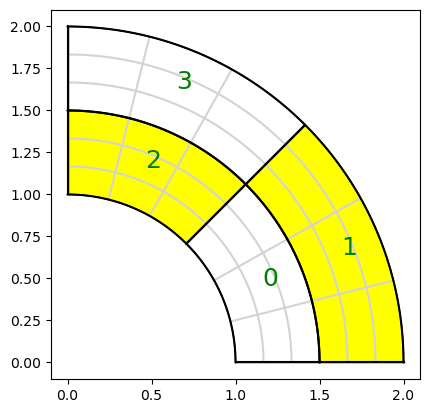

In [65]:
deg = 2
N = 3
#M = Tshapes(deg,N,1)
knots= (bspline.make_knots(deg,0,1,N),bspline.make_knots(deg,0,1,N))
M = topology.PatchMesh([(knots,geometry.quarter_annulus())])
M.split_patch(0,axis=None)

M.set_domain_id({'A':{0,3}, 'B':{1,2}})

MP = assemble.Multipatch(M, automatch=True)

dir_data = {0: lambda x,y: 0.}
#MP.set_dirichlet_boundary(dir_data)
f={'A':lambda x,y: 1.,'B':lambda x,y: 1.}
gamma = 1
MP.set_dirichlet_boundary(dir_data)

a = {'A':gamma, 'B':1.}
MP.mesh.draw(knots=1, patch_idx=1, color={'A':"white", 'B':"yellow"})

Kh = np.array([MP.assemble_volume(problem='a*inner(grad(u),grad(v))* dx', arity=2, domain_id=d, a=a[d]) for d in MP.mesh.domains]).sum()
Fh = np.array([MP.assemble_volume(problem='f * v * dx', arity=1, domain_id=d, f=f[d], physical=True) for d in MP.mesh.domains]).sum(axis=0)
dir_bcs = MP.compute_dirichlet_bcs(dir_data)
LS = assemble.RestrictedLinearSystem(Kh,Fh,dir_bcs)
u_exact = LS.complete(scipy.sparse.linalg.spsolve(LS.A,LS.b))

MP.Constr = parametersort(MP,a)
#parametersort(MP,a)
I = IetiDP(MP, dir_data = dir_data, elim=0)
I.assemble(problem='a*inner(grad(u),grad(v))* dx',f=f, a=a)
I.construct_primal_constraints(redundant=False, fat = False)
I.construct_primal_basis()
I.remove_dir_from_system()

F,b = I.compute_F()
F_mat = F@np.eye(F.shape[0])
#I.compute_S()

MsD = I.MsD(method='deluxe')

lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=MsD, output=1, rtol=1e-6, atol=1e-12)
uh = I.construct_solution(lam)

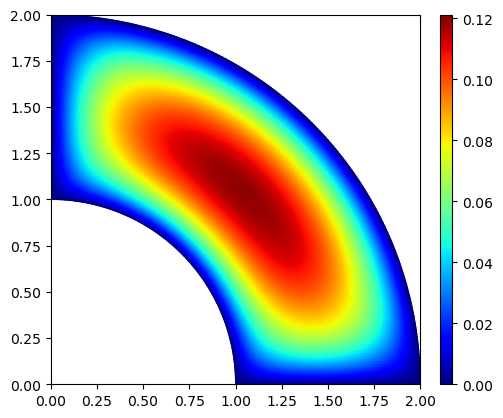

In [67]:
MP.plot(u_exact)

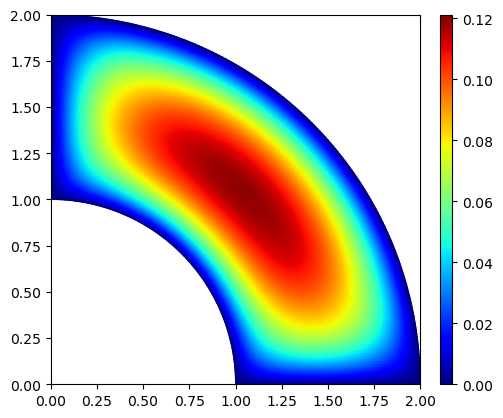

In [68]:
MP.plot(uh)

In [36]:
cell_ind=adap.mp_resPois2(MP,uh,a=a,f=f)
patch_ind=np.array([(cell_ind[MP.Z_ofs[p]:MP.Z_ofs[p+1]]).sum() for p in range(MP.numpatches)])
err_est = norm(patch_ind)
#print(patch_ind[-1])
            
marked_cells = adap.doerfler_mark(cell_ind, theta=0.9,TOL=0.05)
idx=np.zeros(MP.Z_ofs[-1])
idx[marked_cells]=1
cell_ratio = np.array([idx[MP.Z_ofs[p]:MP.Z_ofs[p+1]].sum()/MP.Z[p] for p in range(MP.numpatches)])
err_mean = np.array([np.mean(abs(cell_ind[MP.Z_ofs[p]:MP.Z_ofs[p+1]]-np.mean(cell_ind[MP.Z_ofs[p]:MP.Z_ofs[p+1]]))/np.mean(cell_ind[MP.Z_ofs[p]:MP.Z_ofs[p+1]])) for p in range(MP.numpatches)])
#marked_patches = adap.doerfler_mark(patch_ind[-1], theta, TOL=0.05)

residual contributions took 0.17604398727416992 seconds.
jump contributions took 0.19736599922180176 seconds.


In [53]:
Kh

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 1369 stored elements and shape (81, 81)>

In [30]:
MP.Z_ofs

array([  0,   9,  18,  27,  36,  45,  54,  63,  72,  81,  90,  99, 108, 117])

In [30]:
degs = (2,3,5,8)
maxiter=11
R = np.zeros((maxiter,4*len(degs)))
for i,deg in enumerate(degs):
    N = deg+1
    M = Heat_annulus(deg,N)
    MP = assemble.Multipatch(M, automatch=True)
    
    dir_data = {0: lambda x,y: 0.}
    MP.set_dirichlet_boundary(dir_data)
    uh=[]
    P=[]
    err_ind=[]
    
    numdofs =np.zeros(maxiter)
    err_est=np.zeros(maxiter)
    a = {0:1., 1:1e4}
    f={0:lambda x,y: 1.,1:lambda x,y: 1.}
    
    MP.Constr = parametersort(MP,a)
    
    for k in range(maxiter):
        print(k)
        n_p = MP.numpatches
        #MP.mesh.draw(knots=1,patch_idx=0,color={0:'white',1:'yellow'},bcolor={0:'blue'})
        #plt.show()
        
        ###IETI Solver
        I = IetiDP(MP, dir_data = dir_data, elim=0)
        I.assemble(problem='a*inner(grad(u),grad(v))* dx',f=f, a=a)
        I.construct_primal_constraints(redundant=False, fat = 0)
        I.construct_primal_basis()
        I.remove_dir_from_system()
    
        F,b = I.compute_F()
    
        # t = time.time()
        # MsD1 = I.MsD(method='selection', as_matrix=False)
        # print(time.time()-t)
        t = time.time()
        I.compute_S()
        print(time.time()-t)
        
        #MsD = I.MsD(method='selection', as_matrix=False)
        MsD = MsD_deluxe_Op(I)
    
    
        lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=MsD, output=1, rtol=1e-6, atol=1e-12)
        #print(it)
        R[k,4*i]  = MP.numpatches
        R[k,4*i+1] = MP.N_ofs[-1]
        R[k,4*i+2]= abs(max_eig/min_eig)
        R[k,4*i+3]= it
        uh_k = I.construct_solution(lam)
        uh.append(uh_k)
        numdofs[k] = MP.N_ofs[-1]
        #print(MP_a.numdofs)
        
        if k < maxiter-1 :
            err_ind.append(adap.mp_resPois2(MP,uh[k],a=a, f=f))
            err_est[k] = norm(err_ind[-1])
            marked_patches = adap.doerfler_mark(err_ind[-1], 0.9, TOL=0)
            marked_patches = {p:None for p in marked_patches}
            #print(marked_patches)
            MP.h_refine(h_ref=marked_patches,ref="rs")
            marked_patches = consistency_split(MP)
            # MP.h_refine(h_ref=marked_patches,ref="rs")
            # MP.set_dirichlet_boundary(dir_data)
            MP.Constr = parametersort(MP,a)
#np.savetxt('IETI_adaptive_deluxe.txt', R, fmt=len(degs)*('%d','%1.2e', '%1.3f','%d'), delimiter = ' & ', newline='\\\\\n')
#np.savetxt('IETI_adaptive_selection.txt', R, fmt=len(degs)*('%d', '%1.2e', '%1.3f','%d'),delimiter = ' & ', newline='\\\\\n')
np.savetxt('IETI_adaptive_selection_consistency.txt', R, fmt=len(degs)*('%d', '%1.2e', '%1.3f','%d'),delimiter = ' & ', newline='\\\\\n')

setting up constraints took 0.011977195739746094 seconds.
Basis setup took 0.004736423492431641 seconds
0
0.00744318962097168
pcg with preconditioned condition number κ ~ 2.393470692319492 stopped after 7 iterations with relres 2.2768103549747936e-08


ValueError: dimension mismatch

In [39]:
def Inductor(deg,N):
    kvs=42*[2*(bspline.make_knots(deg,0.0,1.0,N),)]
    
    geos=[      
        geometry.unit_square().scale((0.5)).translate((-0.5,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((0,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((0.25,-0.5)),
        geometry.unit_square().scale((0.5,0.5)).translate((0.5,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.25,-0.5)),
        geometry.unit_square().scale(0.5).translate((1.5,-0.5)),
        
        geometry.unit_square().scale((0.5,0.25)).translate((-0.5,0)),
        geometry.unit_square().scale(0.25),
        geometry.unit_square().scale(0.25).translate((0.25,0)),
        geometry.unit_square().scale((0.5,0.25)).translate((0.5,0)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.,0)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.25,0)),
        geometry.unit_square().scale((0.5,0.25)).translate((1.5,0)),
        
        geometry.unit_square().scale((0.5,0.025)).translate((-0.5,0.25)),
        geometry.unit_square().scale((0.25,0.025)).translate((0,0.25)),
        geometry.unit_square().scale((0.25,0.025)).translate((0.25,0.25)),
        geometry.unit_square().scale((0.5,0.025)).translate((0.5,0.25)),
        geometry.unit_square().scale((0.25,0.025)).translate((1.,0.25)),
        geometry.unit_square().scale((0.25,0.025)).translate((1.25,0.25)),
        geometry.unit_square().scale((0.5,0.025)).translate((1.5,0.25)),
        
        geometry.unit_square().scale((0.5,0.5)).translate((-0.5,0.275)),
        geometry.unit_square().scale((0.25,0.5)).translate((0,0.275)),
        geometry.unit_square().scale((0.25,0.5)).translate((0.25,0.275)),
        geometry.unit_square().scale((0.5,0.5)).translate((0.5,0.275)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.,0.275)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.25,0.275)),
        geometry.unit_square().scale((0.5,0.5)).translate((1.5,0.275)),
        
        geometry.unit_square().scale((0.5,0.25)).translate((-0.5,0.775)),
        geometry.unit_square().scale((0.25,0.25)).translate((0,0.775)),
        geometry.unit_square().scale((0.25,0.25)).translate((0.25,0.775)),
        geometry.unit_square().scale((0.5,0.25)).translate((0.5,0.775)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.,0.775)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.25,0.775)),
        geometry.unit_square().scale((0.5,0.25)).translate((1.5,0.775)),
        
        geometry.unit_square().scale(0.5).translate((-0.5,1.025)),
        geometry.unit_square().scale((0.25,0.5)).translate((0,1.025)),
        geometry.unit_square().scale((0.25,0.5)).translate((0.25,1.025)),
        geometry.unit_square().scale((0.5,0.5)).translate((0.5,1.025)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.,1.025)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.25,1.025)),
        geometry.unit_square().scale(0.5).translate((1.5,1.025)),
         ]
    patches=list(zip(kvs,geos))
    M = topology.PatchMesh(patches)
    M.rename_domain(0,'Air')
    M.set_domain_id({'Fe':{8,9,10,11,12,22,24,26,29,30,31,32,33}, 'C1':{23}, 'C2':{25}})
    return M

In [103]:
mu0 = 4*pi*1e-7
nu = {'C1': 1/mu0, 'C2':1/mu0, 'Fe':1/(2500*mu0), 'Air': 1/mu0}
j = {'C1': lambda x,y: 66/(0.125), 'C2':lambda x,y: -66/(0.125), 'Fe':lambda x,y: 0.0, 'Air': lambda x,y: 0.0}
MaT = {'C1': lambda x,y: (0.,0.), 'C2': lambda x,y:(0.,0.), 'Fe':lambda x,y:(0.,0.), 'Air': lambda x,y:(0.,0.)}

setting up constraints took 0.10493302345275879 seconds.
Basis setup took 0.011682748794555664 seconds
0


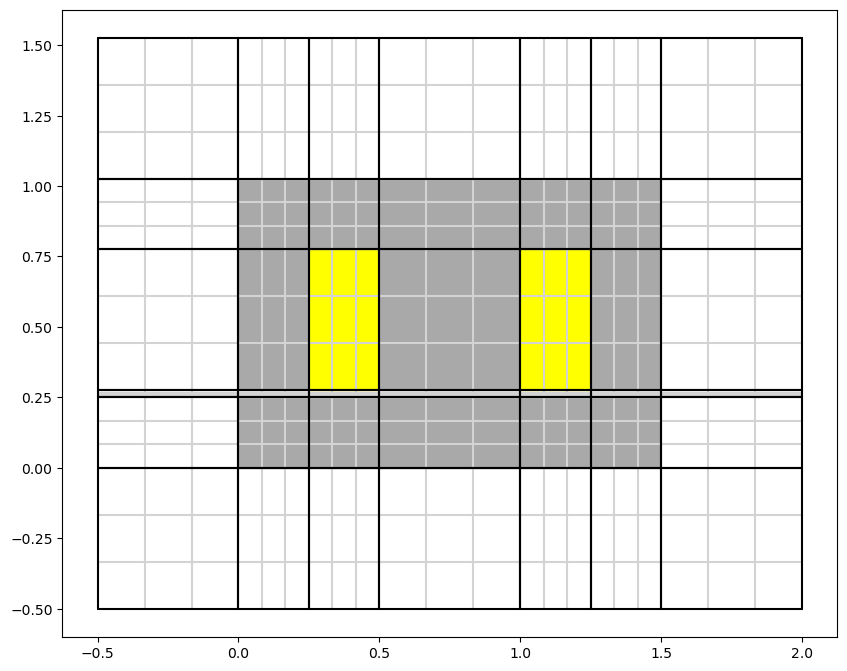

0.08096742630004883
pcg with preconditioned condition number κ ~ 19.80431091155654 stopped after 18 iterations with relres 5.975313507793852e-07
Residual contributions took 0.26596641540527344 seconds.
Jump contributions took 0.44369006156921387 seconds.
[ 0.556  0.896  0.013  0.008  0.013  0.896  0.556  9.104  5.866  0.087  0.012  0.087  5.866  9.104  21.954  12.343  17.463  13.240  17.463  12.343  21.954  9.624  6.528  20.507  7.163  20.507  6.528  9.624  0.301  0.130  0.166  0.035  0.166  0.130  0.301  0.086  0.159  0.003  0.001  0.003  0.159  0.086]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]
Residual contributions took 0.2622561454772949 seconds.
Jump contributions took 0.44084978103637695 seconds.
Refinement took 0.05865812301635742 seconds for 12 patches.
setting up constraints took 0.23844194412231445 seconds.
Basis setup took 0.026474714279174805 seconds
1


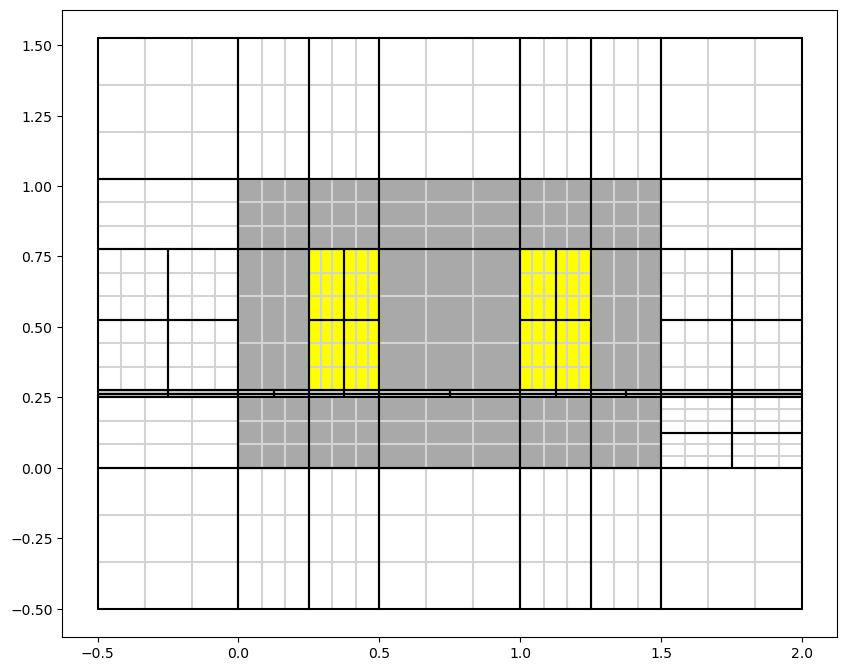

0.13563323020935059
pcg with preconditioned condition number κ ~ 87.2695514963063 stopped after 43 iterations with relres 8.753608765576261e-07
Residual contributions took 0.48488879203796387 seconds.
Jump contributions took 1.0445451736450195 seconds.
[ 0.555  0.895  0.013  0.008  0.013  0.899  0.829  15.033  6.481  3.287  9.127  3.278  6.272  0.899  1.719  5.181  3.737  9.651  3.883  4.281  8.231  0.068  12.345  9.591  17.663  11.571  12.732  8.435  0.246  0.129  0.361  0.035  0.361  0.129  0.260  0.085  0.159  0.003  0.001  0.003  0.159  0.086  0.048  6.274  0.105  7.583  0.034  0.759  0.107  0.819  0.036  4.273  4.985  6.219  4.483  6.242  4.865  9.652  10.227  10.227  3.737  4.850  4.892  3.883  4.897  4.850  9.596  1.510  1.284  11.571  1.283  1.510  15.882  0.200  9.657  0.145  8.974  0.180]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 

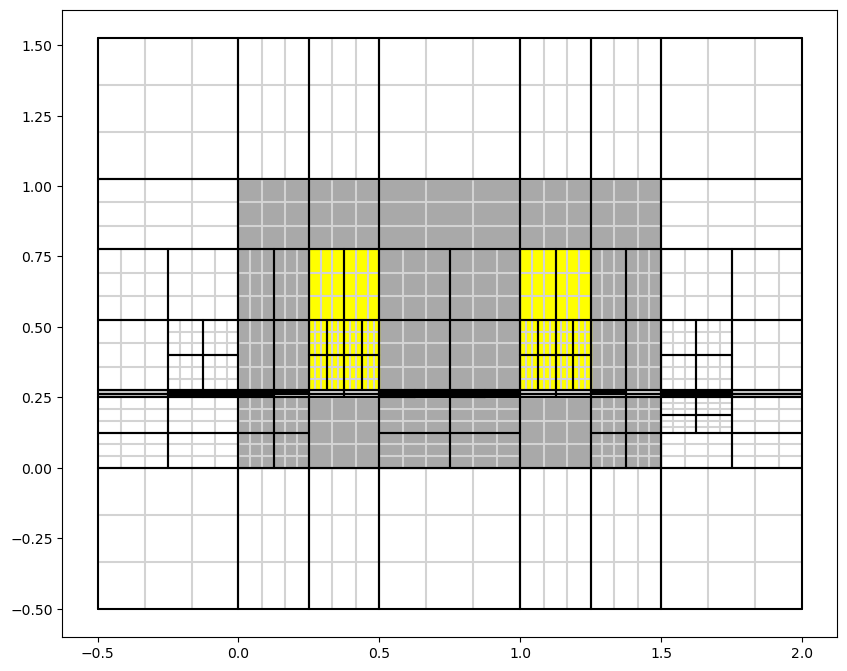

0.2317972183227539
pcg with preconditioned condition number κ ~ 120.59554599217608 stopped after 57 iterations with relres 7.952147509549561e-07
Residual contributions took 0.9466245174407959 seconds.
Jump contributions took 2.3254313468933105 seconds.
[ 0.921  0.864  0.013  0.008  0.013  0.863  0.920  0.054  0.561  4.356  0.000  4.356  0.034  0.902  0.090  2.779  3.802  3.809  3.835  2.725  2.555  0.022  5.417  6.467  8.451  7.497  7.189  5.843  0.130  0.125  0.039  0.058  0.039  0.125  0.130  0.085  0.158  0.003  0.001  0.003  0.158  0.085  0.054  0.270  0.013  0.040  0.015  0.145  0.026  0.150  0.015  2.786  1.012  0.304  4.468  1.895  4.864  0.639  2.412  0.087  3.801  3.374  4.659  3.835  4.661  3.374  0.386  0.229  0.195  0.241  0.195  0.229  1.035  0.029  0.038  0.010  1.734  0.013  0.031  2.511  0.224  0.268  1.057  0.109  1.895  0.687  4.139  0.319  4.140  0.715  0.562  0.194  4.147  0.031  4.489  0.072  0.034  4.671  0.225  5.619  0.026  0.564  0.036  1.595  0.027  0.062  0.5

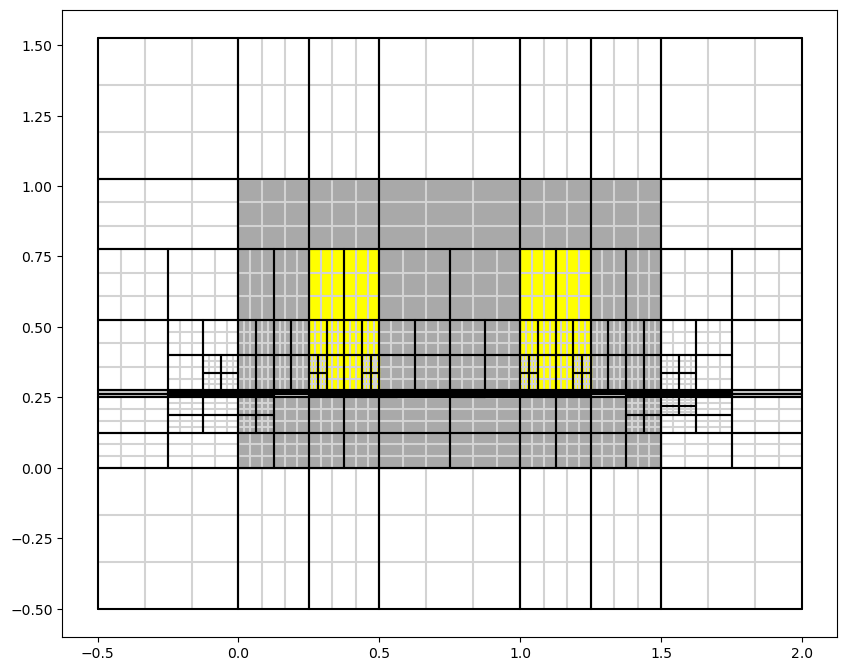

0.3920443058013916
pcg with preconditioned condition number κ ~ 118.58381114441387 stopped after 64 iterations with relres 9.181964468613372e-07
Residual contributions took 1.6084935665130615 seconds.
Jump contributions took 4.02856707572937 seconds.
[ 0.920  0.863  0.013  0.008  0.013  0.863  0.920  0.054  0.561  0.004  0.000  0.001  0.034  0.903  0.012  2.829  0.731  0.903  0.889  1.305  3.338  0.026  3.476  4.026  6.430  4.893  4.648  3.485  0.130  0.125  0.040  0.058  0.040  0.125  0.130  0.085  0.158  0.003  0.001  0.003  0.158  0.085  0.054  0.107  0.013  0.029  0.015  0.026  0.026  0.026  0.015  1.305  1.126  0.088  0.123  1.339  0.031  0.175  2.686  0.104  0.054  0.787  0.016  0.077  0.630  0.015  0.256  0.038  0.031  0.278  0.031  0.038  0.048  0.015  0.028  0.011  1.494  0.013  0.032  2.840  0.112  0.131  1.108  0.103  1.339  0.076  0.205  0.088  1.049  0.076  0.561  0.059  0.000  0.025  0.153  0.024  0.034  0.038  0.059  0.029  0.018  0.094  0.065  1.431  0.027  0.034  0.093

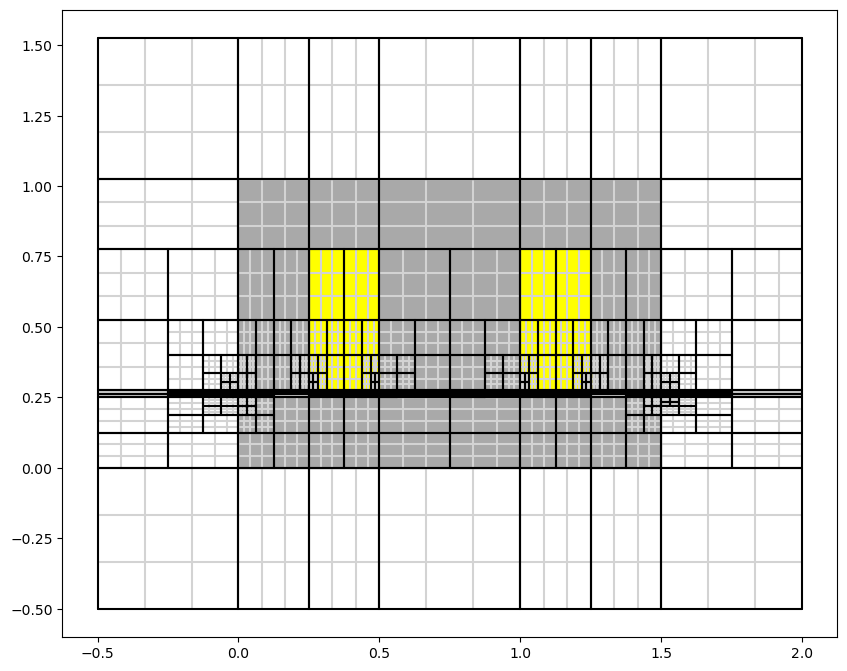

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2014 but corresponding boolean dimension is 2015

In [128]:
degs = (2,)
maxiter=5
R = np.zeros((maxiter,4*len(degs)))
for i,deg in enumerate(degs):
    N = deg+1
    M = Inductor(deg,N)
    MP = assemble.Multipatch(M, automatch=True)
    dir_data = {0: lambda x,y: 0.}
    MP.set_dirichlet_boundary(dir_data)
    uh=[]
    P=[]
    err_ind=[]
    
    numdofs =np.zeros(maxiter)
    err_est=np.zeros(maxiter)
    
    MP.Constr = parametersort(MP,nu)
    for k in range(maxiter):
        print(k)
        n_p = MP.numpatches
        MP.mesh.draw(figsize=(10,10),color={'C1':'yellow', 'C2':'yellow', 'Fe':'darkgrey', 'Air':'white'}, knots=1, bwidth=0.01)
        plt.show()
        
        ###IETI Solver
        I = IetiDP(MP, dir_data = dir_data, elim=0)
        I.assemble(problem='a*inner(grad(u),grad(v))* dx',f=j, a=nu)
        I.construct_primal_constraints(redundant=False, fat = 0)
        I.construct_primal_basis()
        I.remove_dir_from_system()
    
        F,b = I.compute_F()
    
        # t = time.time()
        # MsD1 = I.MsD(method='selection', as_matrix=False)
        # print(time.time()-t)
        t = time.time()
        I.compute_S()
        print(time.time()-t)
        
        #MsD = I.MsD(method='selection', as_matrix=False)
        MsD = MsD_deluxe_Op(I)
    
        lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=MsD, output=1, rtol=1e-6, atol=1e-12)
        #print(it)
        R[k,4*i]  = MP.numpatches
        R[k,4*i+1] = MP.N_ofs[-1]
        R[k,4*i+2]= abs(max_eig/min_eig)
        R[k,4*i+3]= it
        uh_k = I.construct_solution(lam)
        uh.append(uh_k)
        numdofs[k] = MP.N_ofs[-1]
        #print(MP_a.numdofs)
        err_ind.append(adap.mp_resPois(MP,uh[k],a=nu, f=j, M=MaT))
        err_est[k] = norm(err_ind[-1])
        print(err_ind[-1])
        print(np.sort(adap.doerfler_mark(err_ind[-1], 0.6)))
        if k < maxiter-1 :
            err_ind.append(adap.mp_resPois(MP,uh[k],a=nu, f=j, M=MaT))
            err_est[k] = norm(err_ind[-1])
            marked_patches = adap.doerfler_mark(err_ind[-1], theta=0.9, TOL=0)
            marked_patches = {p:None for p in marked_patches}
            #print(marked_patches)
            MP.h_refine(h_ref=marked_patches,ref="rs")
            #marked_patches = consistency_split(MP)
            # MP.h_refine(h_ref=marked_patches,ref="rs")
            MP.set_dirichlet_boundary(dir_data)
            #MP.Constr = parametersort(MP,a)
#np.savetxt('IETI_Inductor_adaptive_deluxe.txt', R, fmt=len(degs)*('%d','%1.2e', '%1.3f','%d'), delimiter = ' & ', newline='\\\\\n')
#np.savetxt('IETI_Inductor_adaptive_selection.txt', R, fmt=len(degs)*('%d', '%1.2e', '%1.3f','%d'),delimiter = ' & ', newline='\\\\\n')
#np.savetxt('IETI_Inductor_adaptive_selection_consistency_.txt', R, fmt=len(degs)*('%d', '%1.2e', '%1.3f','%d'),delimiter = ' & ', newline='\\\\\n')

In [60]:
x=np.array(list(MP.mesh.patch_domains.values()))

deg = 2
setting up constraints took 0.020328521728515625 seconds.
Basis setup took 0.008057832717895508 seconds
pcg with preconditioned condition number κ ~ 4.866912722164114 stopped after 12 iterations with relres 4.0196249089061476e-07
#####################################################
setting up constraints took 0.021007776260375977 seconds.
Basis setup took 0.008074045181274414 seconds
pcg with preconditioned condition number κ ~ 6.844477130703723 stopped after 15 iterations with relres 1.2527597848017955e-07
#####################################################
setting up constraints took 0.02991962432861328 seconds.
Basis setup took 0.016133785247802734 seconds
pcg with preconditioned condition number κ ~ 9.146446269810777 stopped after 16 iterations with relres 8.252901247665778e-07
#####################################################
deg = 3
setting up constraints took 0.021846532821655273 seconds.
Basis setup took 0.007699489593505859 seconds
pcg with preconditioned condit

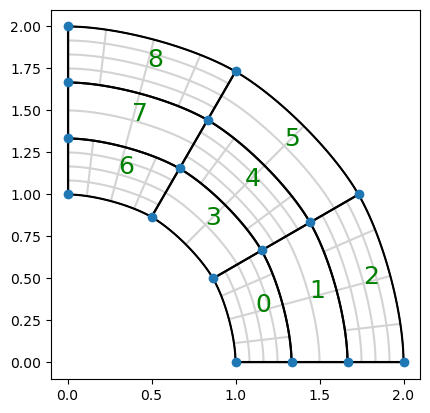

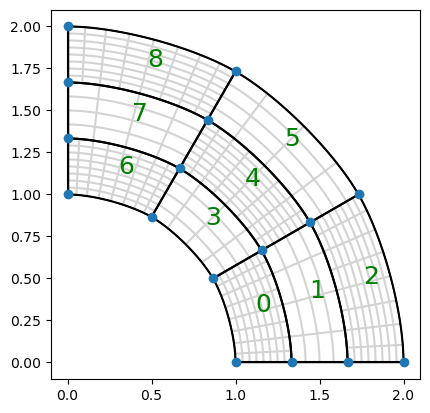

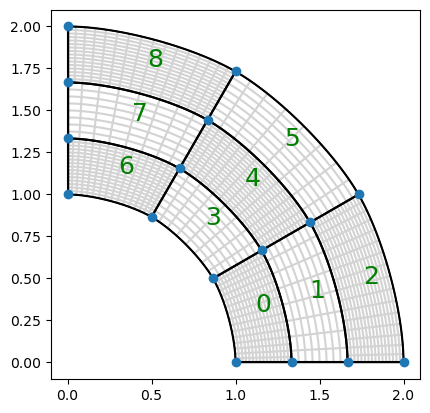

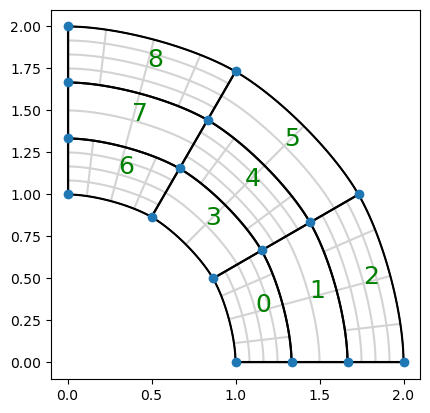

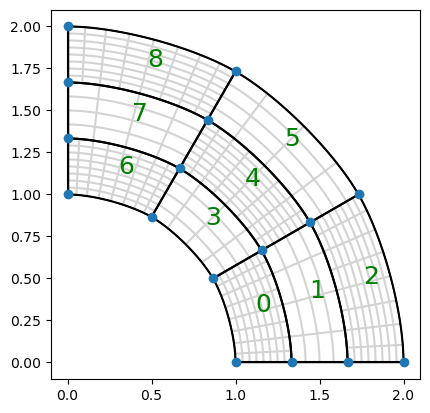

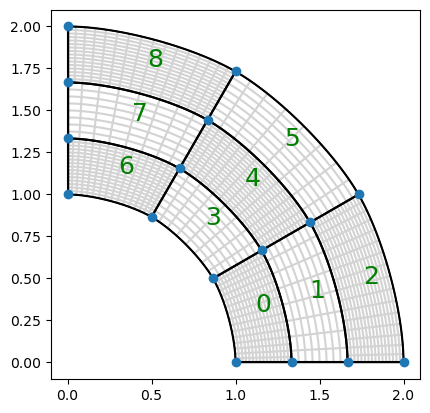

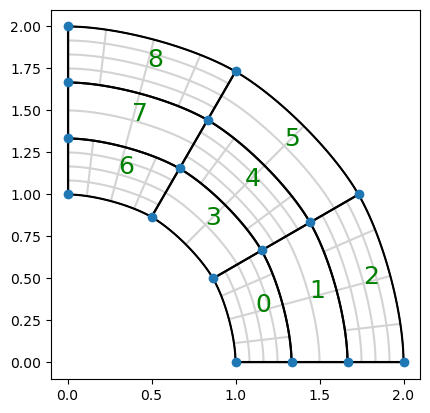

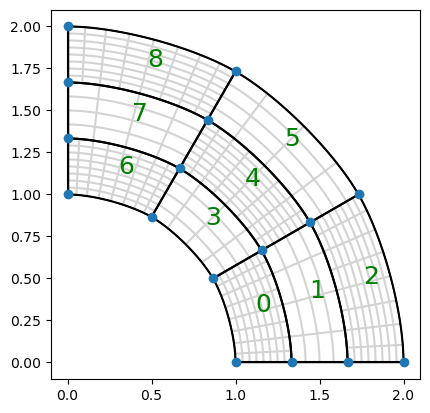

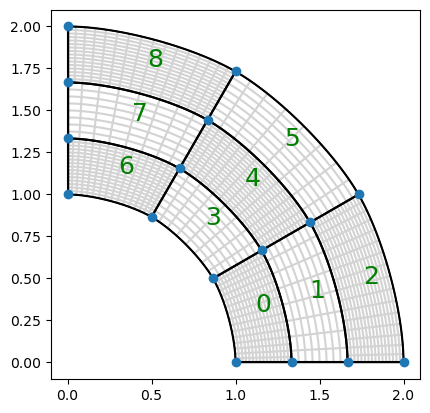

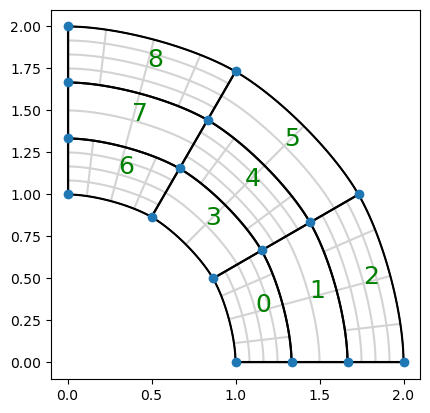

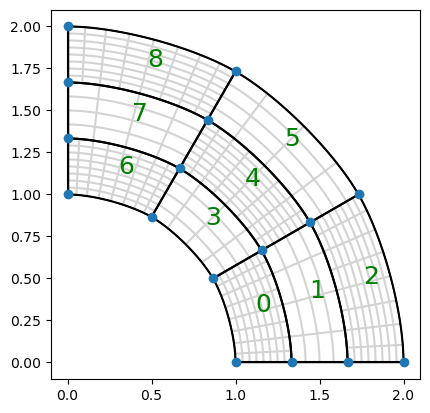

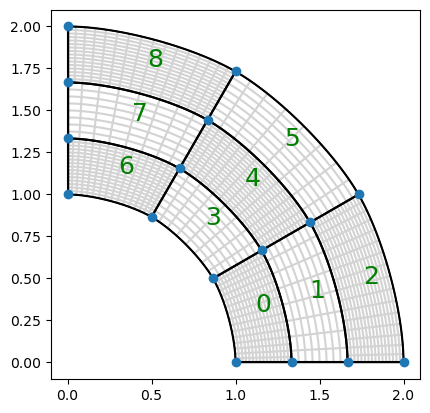

In [119]:
# f = lambda x, y: 1.
g = lambda x, y: 0. 

#params = {'f' : f, 'g' : g}
degs=(2,3,5,8)
maxiter=len(degs)*(3,)
elim=0
fat=0
export=1
a={0:1e6,1:1.}

# num_dofs = np.empty((len(maxiter),len(deg)),dtype=int)
# num_primal = np.empty((len(maxiter),len(deg)),dtype=int)
# min_eig = np.empty((len(maxiter),len(deg)),dtype=float)
# max_eig = np.empty((len(maxiter),len(deg)),dtype=float)
# it = np.empty((len(maxiter),len(deg)),dtype=int)

k=2
res = np.zeros((max(maxiter),len(degs)*k), dtype=float)

for j, deg in enumerate(degs):
    print("======================================================")
    print("deg = "+str(deg))
    for i in range(maxiter[j]):
        M = checkerboard2(deg,2**(i+1),1)
        M.set_domain_id({1:{1,3,5,7}})
        MP = assemble.Multipatch(M, automatch=True)
        N = MP.numpatches
        MP.set_dirichlet_boundary({0:g})
        MP.mesh.draw(patch_idx=1,nodes=1,knots=1)
        I = IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(problem='a * inner( grad(u) , grad(v) )* dx', f={0:lambda x,y: 1.,1:lambda x,y: 1.}, a=a)
        I.construct_primal_constraints(redundant=False, fat=fat)
        I.construct_primal_basis()
        #res[i,k*j] = I.Psi.shape[1]
        I.remove_dir_from_system()
        F,b= I.compute_F()
        #F_mat = F@np.eye(len(b))
        #I.compute_Schur()
        MsD = I.MsD(method="deluxe")
        #MsD_mat = MsD@np.eye(len(b))
        ### Solve the system with PCG
        lam, res[i,k*j], min_eig, max_eig, r = solvers.pcg(F, b, x0=np.random.rand(len(b)), maxiter=2000, P=MsD, output=1, rtol=1e-6, atol=1e-12)
        res[i, k*j+1] = abs(max_eig/min_eig)
        #print(min_eig, max_eig)
        #w = I.construct_solution(lam)
        print("#####################################################")
if export:
    if elim:
        np.savetxt('/home/wolfman/Documents/IETI/checkerboard_elim.txt', res, fmt=len(degs)*('%d','%1.2f'), delimiter = " & ")   
    else:
        np.savetxt('/home/wolfman/Documents/IETI/checkerboard.txt', res, fmt=len(degs)*('%d','%1.2f'), delimiter = " & ")   

In [ ]:
f = lambda x, y: 1.
g = lambda x, y: 0. 

params = {'f' : f, 'g' : g}
degs=(2,3,4,5,6,7,8)
maxiter=len(degs)*(6,)
elim=0
fat=0
export=1

# num_dofs = np.empty((len(maxiter),len(deg)),dtype=int)
# num_primal = np.empty((len(maxiter),len(deg)),dtype=int)
# min_eig = np.empty((len(maxiter),len(deg)),dtype=float)
# max_eig = np.empty((len(maxiter),len(deg)),dtype=float)
# it = np.empty((len(maxiter),len(deg)),dtype=int)

k=2
res = np.zeros((max(maxiter),len(degs)*k), dtype=float)

for j, deg in enumerate(degs):
    print("======================================================")
    print("deg = "+str(deg))
    for d in range(maxiter[j]):
        M = checkerboard1(deg,2,d+1)
        MP = assemble.Multipatch(M, automatch=True)
        MP.set_dirichlet_boundary({0:g})
        #MP.mesh.draw(patch_idx=1,nodes=1,knots=1)
        I = IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(problem='(inner(grad(u),grad(v)))* dx',f={ k:lambda x,y: 1. for k in range(N)}, a={ k:lambda x,y: 1. for k in range(N)})
        I.construct_primal_constraints(redundant=False, fat=fat)
        I.construct_primal_basis()
        #res[i,k*j] = I.Psi.shape[1]
        I.remove_dir_from_jumps()
        F,b= I.compute_F()
        #F_mat = F@np.eye(len(b))
        MsD = I.MsD(method="choice")
        #MsD_mat = MsD@np.eye(len(b))
        ### Solve the system with PCG
        lam, res[d,k*j], min_eig, max_eig, r = solvers.pcg(F, b, x0=np.random.rand(len(b)), maxiter=100, P=MsD, output=1, rtol=1e-6, atol=1e-12)
        res[d, k*j+1] = abs(max_eig/min_eig)
        #print(min_eig, max_eig)
        #w = I.construct_solution(lam)
        print("#####################################################")
if export:
    if elim:
        np.savetxt('/home/wolfman/Documents/IETI/checkerboard_elim_dis.txt', res, fmt=len(degs)*('%d','%1.2f'), delimiter = " & ")   
    else:
        np.savetxt('/home/wolfman/Documents/IETI/checkerboard_dis.txt', res, fmt=len(degs)*('%d','%1.2f'), delimiter = " & ")   

In [165]:
f = lambda x, y: 1.
g = lambda x, y: 0. 

params = {'f' : f, 'g' : g}
degs=(2,3,5,8)
maxiter=len(degs)*(4,)
elim=0
fat=0
export=1

# num_dofs = np.empty((len(maxiter),len(deg)),dtype=int)
# num_primal = np.empty((len(maxiter),len(deg)),dtype=int)
# min_eig = np.empty((len(maxiter),len(deg)),dtype=float)
# max_eig = np.empty((len(maxiter),len(deg)),dtype=float)
# it = np.empty((len(maxiter),len(deg)),dtype=int)

k=2
res = np.zeros((max(maxiter),len(degs)*k), dtype=float)

for j, deg in enumerate(degs):
    print("======================================================")
    print("deg = "+str(deg))
    for i in range(maxiter[j]):
        M = Lshape(deg,2**(i+1),5)
        MP = assemble.Multipatch(M, automatch=True)
        N = MP.numpatches
        #res[i,k*j] = MP.N_ofs[-1]
        MP.set_dirichlet_boundary({0:g})
        #MP.mesh.draw(patch_idx=1,nodes=1,knots=1)
        I = IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(problem='(inner(grad(u),grad(v)))* dx',f={ k:lambda x,y: 1. for k in range(N)}, a={ k:lambda x,y: 1. for k in range(N)})
        I.construct_primal_constraints(redundant=False, fat=fat)
        I.construct_primal_basis()
        print(I.Psi.shape[1])
        I.remove_dir_from_system()
        F,b= I.compute_F()
        #F_mat = F@np.eye(len(b))
        MsD = I.MsD(method="deluxe")
        #MsD_mat = MsD@np.eye(len(b))
        ### Solve the system with PCG
        #x0=np.random.rand(len(b))
        x0=None
        lam, res[i,k*j], min_eig, max_eig, r = solvers.pcg(F, b, x0=x0, maxiter=200, P=MsD, output=1, rtol=1e-6, atol=1e-12)
        #print(min_eig, max_eig)
        res[i,k*j+1]=abs(max_eig/min_eig)
        #print(min_eig, max_eig)
        #w = I.construct_solution(lam)
        print("#####################################################")
if export:
    if elim:
        if fat:
            np.savetxt('/home/wolfman/Documents/IETI/Lshape_elim_fat.txt', res, fmt=len(degs)*('%d', '%1.2f'), delimiter = " & ")   
        else:
            np.savetxt('/home/wolfman/Documents/IETI/Lshape_elim.txt', res, fmt=len(degs)*('%d', '%1.2f'), delimiter = " & ") 
    else:
        np.savetxt('/home/wolfman/Documents/IETI/Lshape.txt', res, fmt=len(degs)*('%d', '%1.2f'), delimiter = " & ")   

deg = 2
setting up constraints took 0.13743233680725098 seconds.
Basis setup took 0.0164334774017334 seconds
49
pcg with preconditioned condition number κ ~ 5.672835943596938 stopped after 16 iterations with relres 4.6732528639194114e-07
#####################################################
setting up constraints took 0.142197847366333 seconds.
Basis setup took 0.016907453536987305 seconds
49
pcg with preconditioned condition number κ ~ 8.81675154323183 stopped after 18 iterations with relres 5.947188239080794e-07
#####################################################
setting up constraints took 0.15126681327819824 seconds.
Basis setup took 0.019551753997802734 seconds
49
pcg with preconditioned condition number κ ~ 13.437801942087457 stopped after 21 iterations with relres 5.856498528403269e-07
#####################################################
setting up constraints took 0.1742088794708252 seconds.
Basis setup took 0.02640557289123535 seconds
49
pcg with preconditioned condition nu

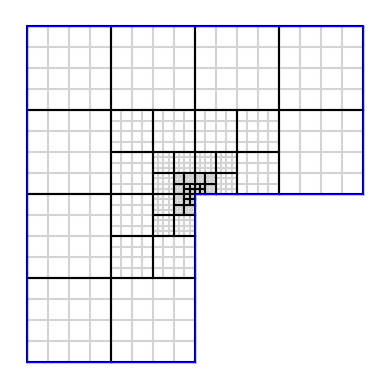

In [27]:
M = Lshape(1,4,5)
M.draw(bcolor={0:'blue'}, nodes=0, knots=1)
axis('off');

In [8]:
I.Ck

[<1x36 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Row format>,
 <2x42 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Row format>,
 <2x42 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Row format>,
 <1x36 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Row format>,
 <2x42 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Row format>,
 <2x42 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Row format>,
 <3x49 sparse matrix of type '<class 'numpy.float64'>'
 	with 3 stored elements in Compressed Sparse Row format>,
 <1x36 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Row format>,
 <2x42 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compr

In [9]:
I.Prim

{0: (array([ 48, 189, 202, 245], dtype=int32), array([1., 1., 1., 1.])),
 1: (array([ 97, 336, 349, 392], dtype=int32), array([1., 1., 1., 1.])),
 2: (array([140, 342, 398, 490], dtype=int32), array([1., 1., 1., 1.])),
 3: (array([146, 483, 496, 539], dtype=int32), array([1., 1., 1., 1.])),
 4: (array([ 55, 244, 287, 294], dtype=int32), array([1., 1., 1., 1.]))}

In [10]:
MP.get_nodes()

{48: [array([ 48, 189, 202, 245], dtype=int32)],
 96: [array([ 97, 336, 349, 392], dtype=int32)],
 138: [array([140, 342, 398, 490], dtype=int32)],
 144: [array([146, 483, 496, 539], dtype=int32)],
 252: [array([ 55, 244, 287, 294], dtype=int32)]}

#####################################
setting up constraints took 0.018363237380981445 seconds.
Basis setup took 0.009409666061401367 seconds
4
10
pcg with preconditioned condition number 1.1104232399228329 stopped after 2 iterations with relres 5.4951067048262263e-17
Refinement took 0.00043201446533203125 seconds for 9 patches.
setting up constraints took 0.020048141479492188 seconds.
Basis setup took 0.009725570678710938 seconds
7
26
pcg with preconditioned condition number 1.242827242377967 stopped after 6 iterations with relres 9.877262513024327e-15
Refinement took 0.000331878662109375 seconds for 9 patches.
setting up constraints took 0.023079395294189453 seconds.
Basis setup took 0.01008152961730957 seconds
8
23
pcg with preconditioned condition number 1.3131180431114824 stopped after 6 iterations with relres 7.19027091678448e-11
Refinement took 0.0003571510314941406 seconds for 9 patches.
setting up constraints took 0.029850244522094727 seconds.
Basis setup took 0.01311326026916

/home/wolfman/anaconda3/lib/python3.9/site-packages/pyiga-0.1.0-py3.9-linux-x86_64.egg/pyiga/topology.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=kwargs.get('figsize'))


21
25
pcg with preconditioned condition number 1.769266987585349 stopped after 11 iterations with relres 2.2424118613517237e-11
Refinement took 0.0003402233123779297 seconds for 9 patches.
setting up constraints took 0.03714632987976074 seconds.
Basis setup took 0.018062114715576172 seconds
24
24
pcg with preconditioned condition number 1.7675684065257513 stopped after 11 iterations with relres 8.781202012645705e-11
Refinement took 0.00039577484130859375 seconds for 9 patches.
setting up constraints took 0.06232929229736328 seconds.
Basis setup took 0.034009695053100586 seconds
25
24
pcg with preconditioned condition number 1.7590407403296329 stopped after 12 iterations with relres 2.639155553047284e-11
Refinement took 0.00043511390686035156 seconds for 9 patches.
setting up constraints took 0.11404061317443848 seconds.
Basis setup took 0.09270548820495605 seconds


KeyboardInterrupt: 

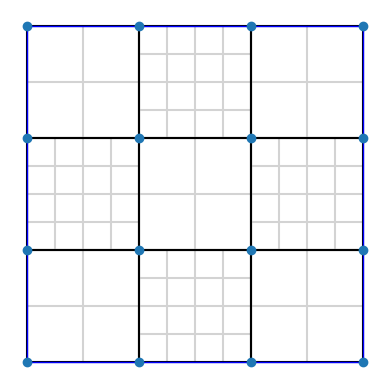

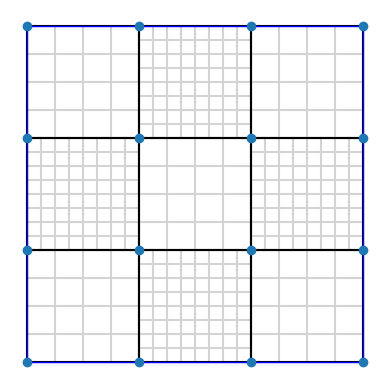

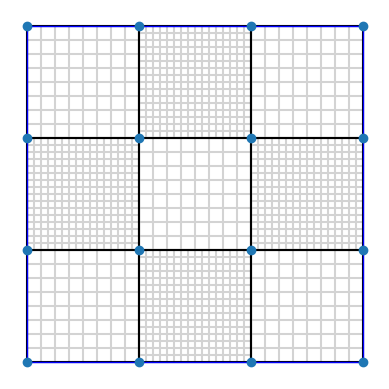

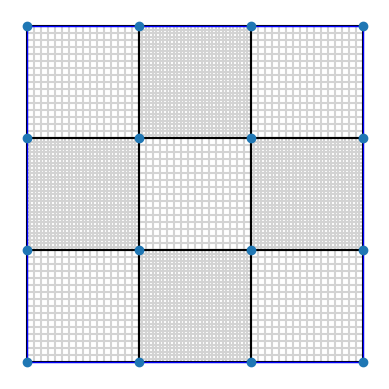

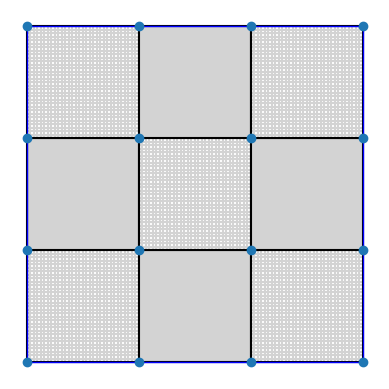

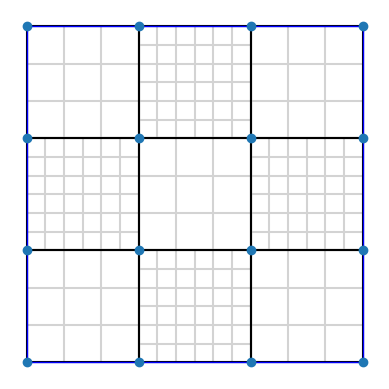

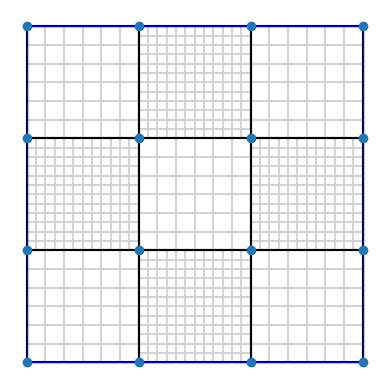

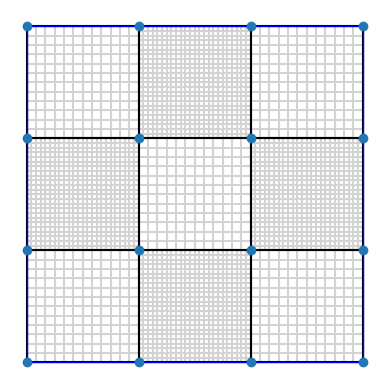

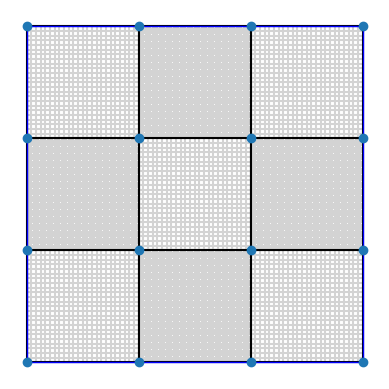

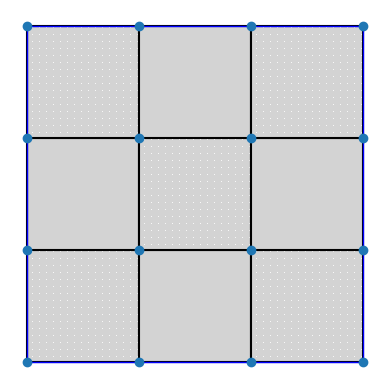

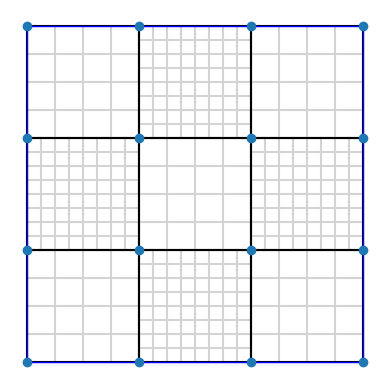

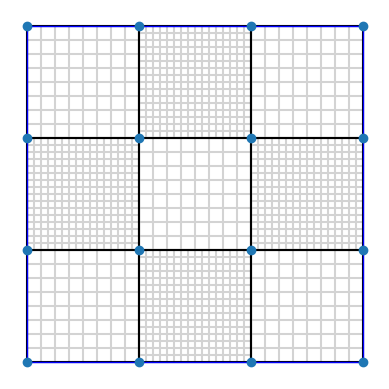

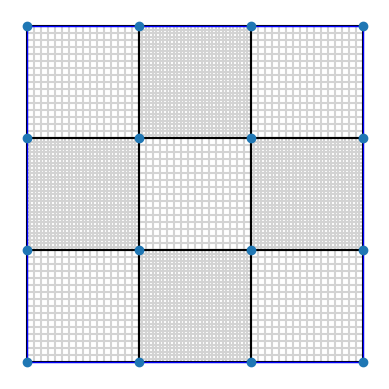

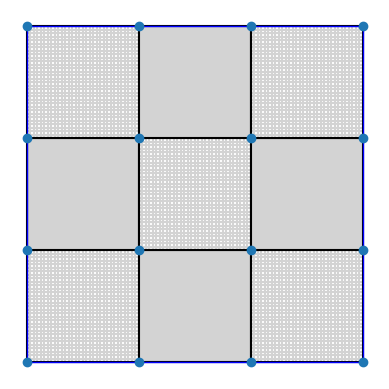

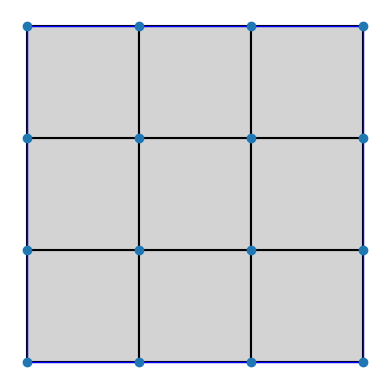

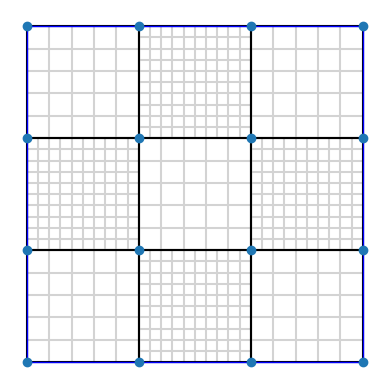

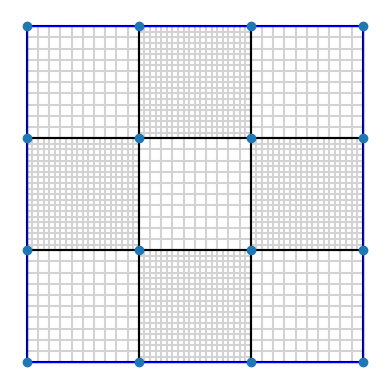

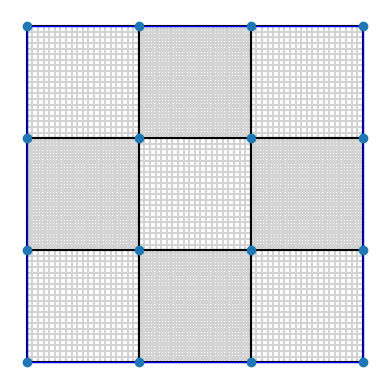

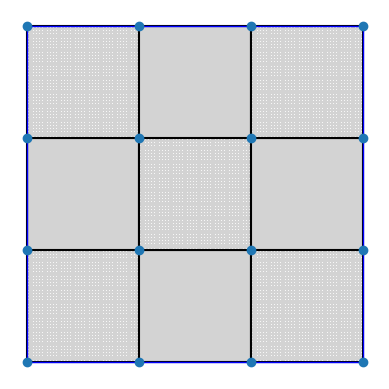

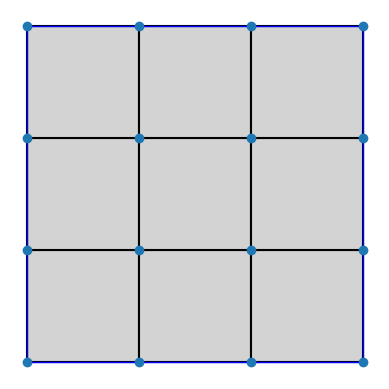

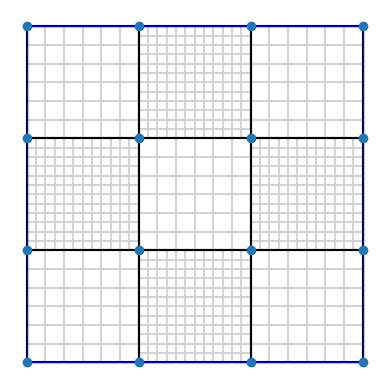

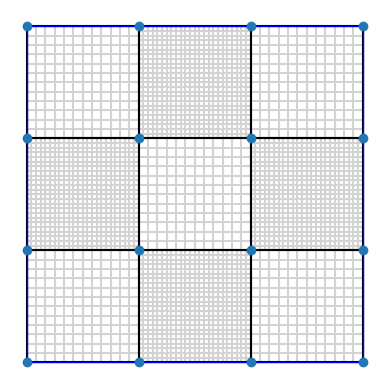

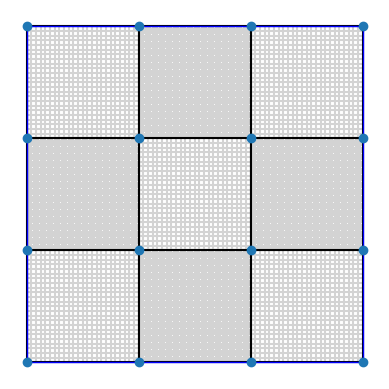

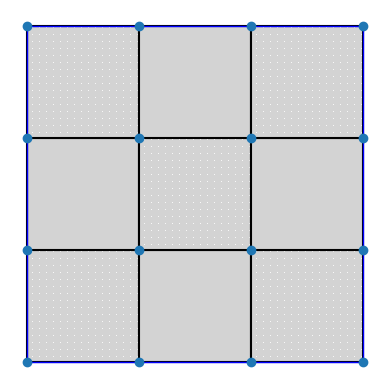

In [16]:
# source term f and Dirichlet boundary function g
f = lambda x, y: 1.
g = lambda x, y: 0. 

kappa = np.zeros((5,5))
it = np.zeros((5,5))
elim=False

for p, (deg, maxiter) in enumerate(zip((1,2,3,4,5),5*(5,))):
    print('#####################################')
    M = checkerboard(deg,deg+1,1)
    MP = assemble.Multipatch(M, automatch=True)
    MP.set_dirichlet_boundary({0:g})
    for i in range(maxiter):
        print('=====================================')
        I = IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(f=lambda x,y: 1.)
        I.construct_primal_constraints()
        I.construct_primal_basis()
        F,b= I.compute_F()
        MsD = I.MsD(pseudo=True)
        Fmat  = F.dot(np.eye(F.shape[0]))
        kappa[i,p]=algebra.condest(MsD@Fmat)
        lam, it[i,p], kappa[i,p], r = solvers.pcg(F, b, x0=None, maxiter=200, P=MsD, output=1, tol=1e-10)
        #MP.mesh.draw(patch_idx = 0, knots=1, bcolor={0:'blue'}, nodes=1, axis='off')
        axis('scaled');
        MP.h_refine(-1)
        ###MP.h_refine({i : -1 for i in range(9) if i%2==1})
        MP.set_dirichlet_boundary({0:g})
        
result = np.zeros((5,10))
result[:,np.array([0,2,4,6,8])]=kappa
result[:,np.array([1,3,5,7,9])]=it

if elim:
    np.savetxt('/home/wolfman/Documents/IETI/checkerboard_elim.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")
else:
    np.savetxt('/home/wolfman/Documents/IETI/checkerboard.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")              

#####################################
setting up constraints took 0.017437458038330078 seconds.
Basis setup took 0.009253501892089844 seconds
pcg stopped after 2 iterations with relres 5.4951067048262263e-17
Refinement took 0.00016951560974121094 seconds for 4 patches.
setting up constraints took 0.01792740821838379 seconds.
Basis setup took 0.00933218002319336 seconds
pcg stopped after 4 iterations with relres 4.273988115438311e-17
Refinement took 0.0001652240753173828 seconds for 4 patches.
setting up constraints took 0.019681930541992188 seconds.
Basis setup took 0.009746074676513672 seconds
pcg stopped after 4 iterations with relres 9.358588499822341e-15
Refinement took 0.00015854835510253906 seconds for 4 patches.
setting up constraints took 0.021558284759521484 seconds.
Basis setup took 0.011844396591186523 seconds
pcg stopped after 4 iterations with relres 4.58228236822898e-13
Refinement took 0.00017547607421875 seconds for 4 patches.
setting up constraints took 0.02753949165344

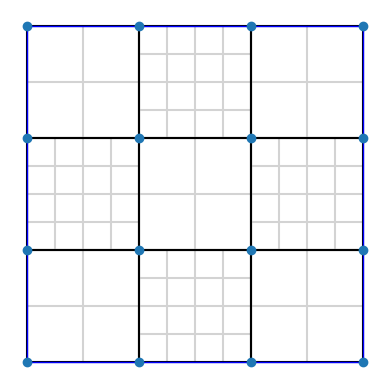

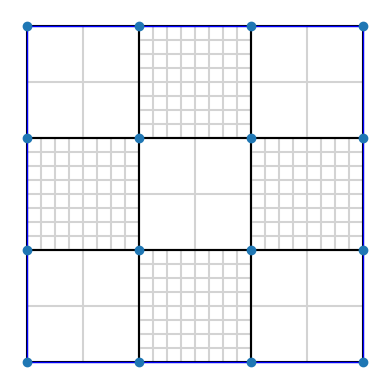

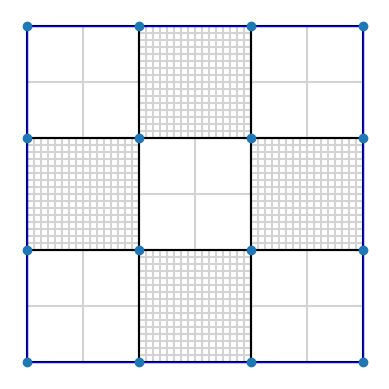

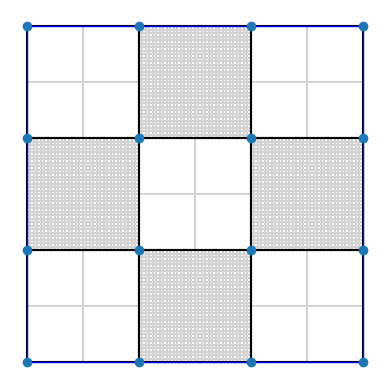

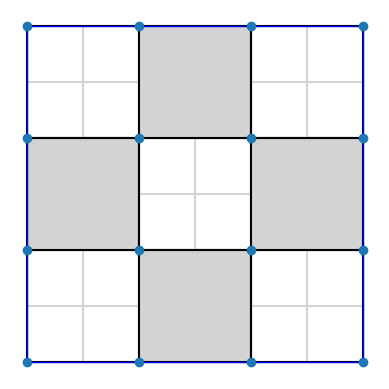

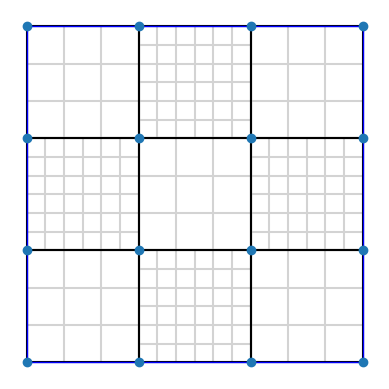

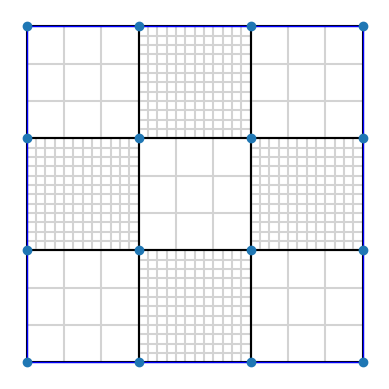

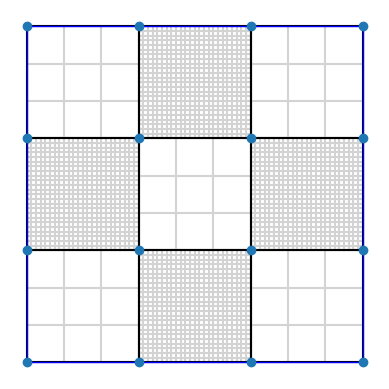

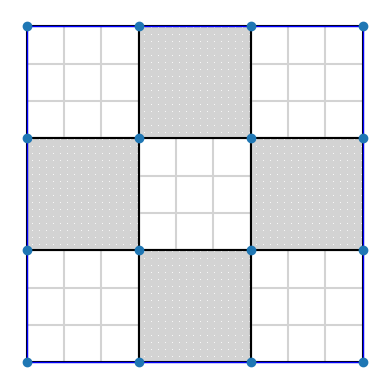

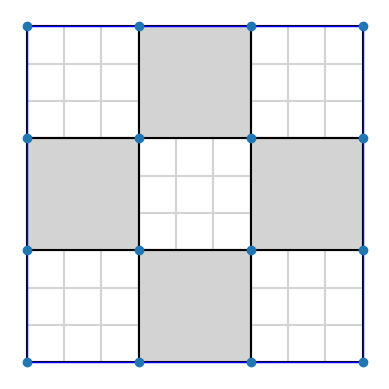

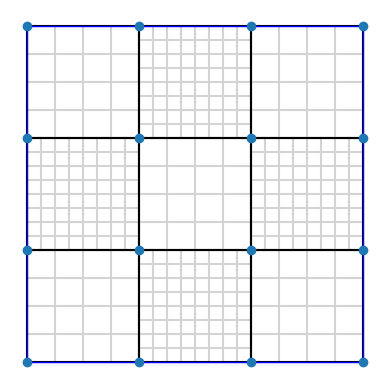

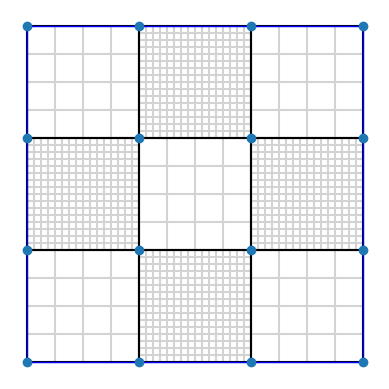

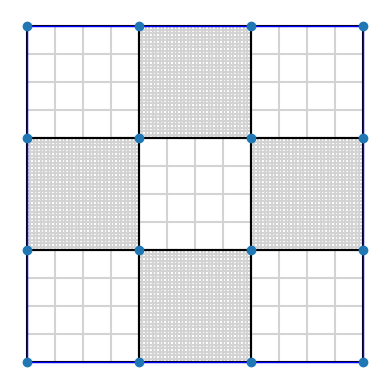

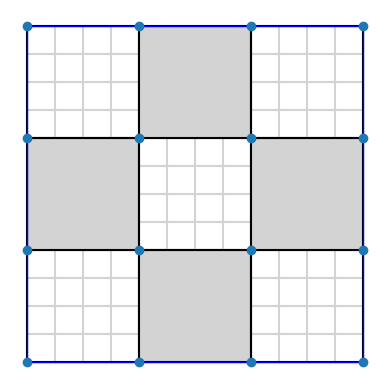

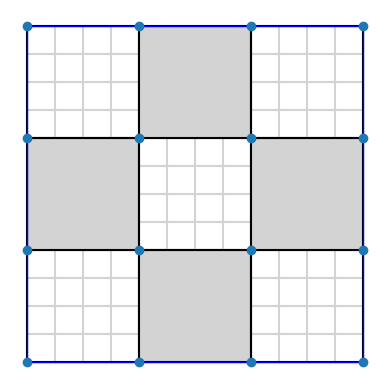

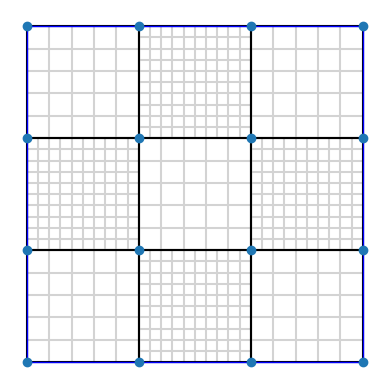

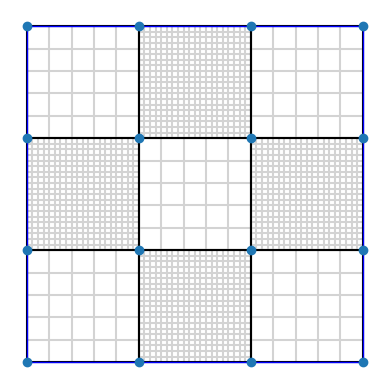

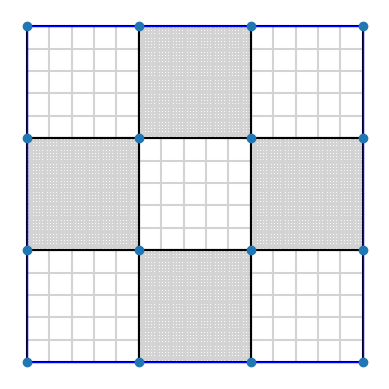

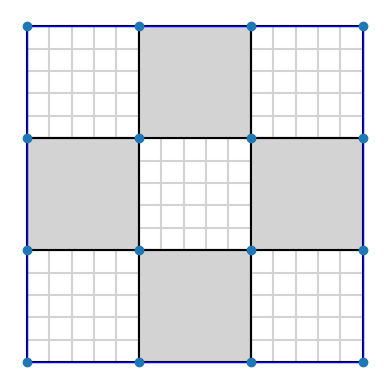

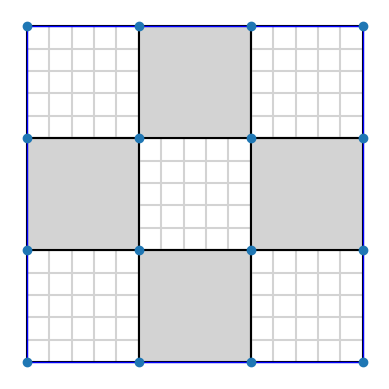

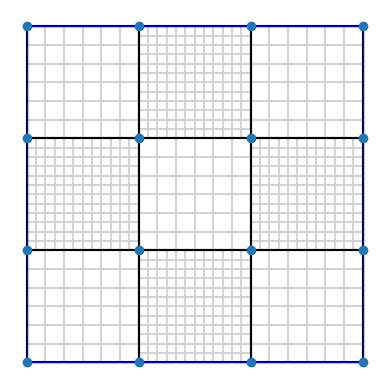

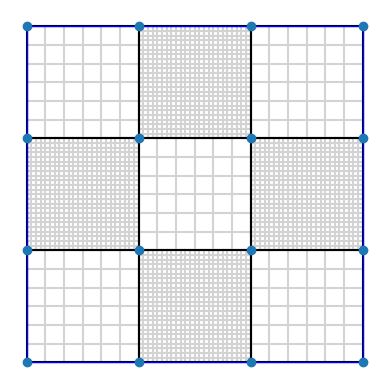

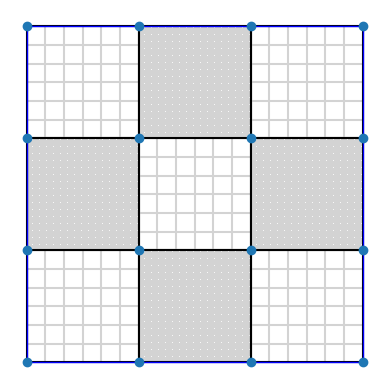

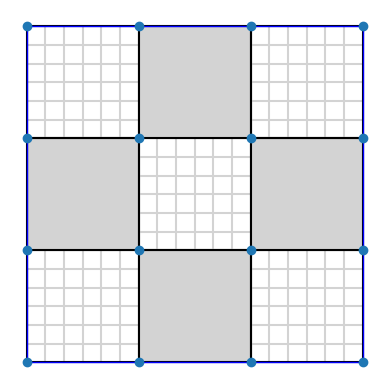

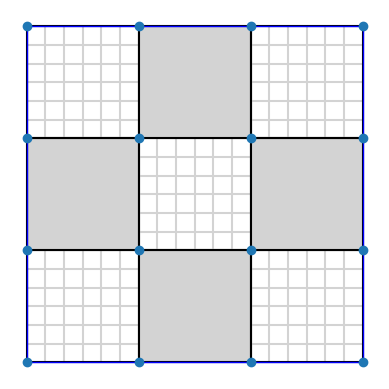

In [49]:
# source term f and Dirichlet boundary function g
f = lambda x, y: 1.
g = lambda x, y: 0. 

kappa = np.zeros((5,5))
it = np.zeros((5,5))
elim=False

for p, (deg, maxiter) in enumerate(zip((1,2,3,4,5),5*(5,))):
    print('#####################################')
    M = checkerboard(deg,deg+1,1)
    MP = assemble.Multipatch(M, automatch=True)
    MP.set_dirichlet_boundary({0:g})
    for i in range(maxiter):
        print('=====================================')
        I = IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(f=lambda x,y: 1.)
        I.construct_primal_constraints()
        I.construct_primal_basis()
        F,b= I.compute_F()
        MsD = I.MsD()
        Fmat  = F.dot(np.eye(F.shape[0]))
        kappa[i,p]=algebra.condest(MsD@Fmat)
        lam, it[i,p], r = solvers.pcg(F, b, x0=None, maxiter=200, P=MsD, output=1, tol=1e-10)
        #MP.mesh.draw(patch_idx = 0, knots=1, bcolor={0:'blue'}, nodes=1, axis='off')
        axis('scaled');
        ###MP.h_refine(-1)
        MP.h_refine({i : -1 for i in range(9) if i%2==1})
        MP.set_dirichlet_boundary({0:g})
        
result = np.zeros((5,10))
result[:,np.array([0,2,4,6,8])]=kappa
result[:,np.array([1,3,5,7,9])]=it

if elim:
    np.savetxt('/home/wolfman/Documents/IETI/checkerboard_elim_dis.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")
else:
    np.savetxt('/home/wolfman/Documents/IETI/checkerboard_dis.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")              

In [ ]:
# source term f and Dirichlet boundary function g
f = lambda x, y: 1.
g = lambda x, y: 0. 

kappa = np.zeros((6,5))
it = np.zeros((6,5))
elim=True

for p, (deg, maxiter) in enumerate(zip((1,2,3,4,5),5*(6,))):
    print('#####################################')
    M = Lshape(deg,deg+1)
    MP = assemble.Multipatch(M, automatch=True)
    MP.set_dirichlet_boundary({0:g})
    for i in range(maxiter):
        print('=====================================')
        I = IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(f=lambda x,y: 1.)
        I.construct_primal_constraints()
        I.construct_primal_basis()
        F,b= I.compute_F()
        MsD = I.MsD(pseudo=False)
        lam, it[i,p], kappa[i,p], r = solvers.pcg(F, b, x0=None, maxiter=200, P=MsD, output=1, tol=1e-10)
        axis('scaled');
        MP.h_refine(-1)
        ###MP.h_refine({i : -1 for i in range(9) if i%2==1})
        MP.set_dirichlet_boundary({0:g})
        
result = np.zeros((5,10))
result[:,np.array([0,2,4,6,8])]=kappa
result[:,np.array([1,3,5,7,9])]=it

if elim:
    np.savetxt('/home/wolfman/Documents/IETI/Lshape_elim.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")
else:
    np.savetxt('/home/wolfman/Documents/IETI/Lshape.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")              

#####################################
setting up constraints took 0.08600449562072754 seconds.
Basis setup took 0.014266014099121094 seconds
pcg with preconditioned condition number 1.0972303562262358 stopped after 5 iterations with relres 2.1033830757006824e-11
Refinement took 0.0010564327239990234 seconds for 31 patches.
setting up constraints took 0.07834243774414062 seconds.
Basis setup took 0.013842582702636719 seconds
pcg with preconditioned condition number 1.671463683434546 stopped after 10 iterations with relres 4.9938397508517634e-11
Refinement took 0.0012252330780029297 seconds for 31 patches.
setting up constraints took 0.08354926109313965 seconds.
Basis setup took 0.015346527099609375 seconds
pcg with preconditioned condition number 1.2749844484684212 stopped after 13 iterations with relres 3.0492980297062935e-11
Refinement took 0.00106048583984375 seconds for 31 patches.
setting up constraints took 0.1029202938079834 seconds.
Basis setup took 0.020825624465942383 seconds
